In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
import matplotlib.gridspec as gridspec

from matplotlib import patches
from scipy import stats
from scipy import linalg as sla
from cigma import plot, util

[2026-02-10 06:32:18 - INFO] cffi mode is CFFI_MODE.ANY
[2026-02-10 06:32:18 - INFO] R home found: /home/minhuic/programs/anaconda3/envs/gxct/lib/R
[2026-02-10 06:32:20 - INFO] R library path: /apps/default/lib:/apps/default/lib:
[2026-02-10 06:32:20 - INFO] LD_LIBRARY_PATH: /apps/default/lib:/apps/default/lib:
[2026-02-10 06:32:20 - INFO] Default options to initialize R: rpy2, --quiet, --no-save
[2026-02-10 06:32:22 - INFO] Environment variable "PWD" redefined by R and overriding existing variable. Current: "/ess/home/home1/minhuic", R: "/gpfs/data/ukb-share/dahl/minhuic/GxCTMM/workflow/notebook"
[2026-02-10 06:32:24 - INFO] R is already initialized. No need to initialize.


In [2]:
# par
Hom_g2 = 0.13
Hom_e2 = 0.11

# Main

In [3]:
# simulation parameters
real = np.load('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.npy', allow_pickle=True).item()
jk = np.load('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.free.jk.npy', allow_pickle=True).item()
P = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/P.final.gz', index_col=0)
Overall_bulk = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/op.rmid.gz', index_col=0)
nu = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/nu.final.gz', index_col=0)[real['gene']]
print(f'Number of genes: {len(real["gene"])}')
assert np.all(real['gene'] == nu.columns.to_numpy())
# print(P.head())
# print(nu.head())

N, C = P.shape

# variance components
var_v = np.trace(real['free']['V'] @ (P.values.T @ P.values), 
                    axis1=1, axis2=2) / N
var_w = np.trace(real['free']['W'] @ (P.values.T @ P.values), 
                    axis1=1, axis2=2) / N
S = np.cov(P.values.T)
var_beta = (real['free']['ct_beta'] @ S) * real['free']['ct_beta']
var_beta = var_beta.sum(axis=1)
op = real['free']['hom_g2'] + real['free']['hom_e2'] + var_v + var_w + var_beta + nu.mean().to_numpy()

xs = var_v / op
index = np.argsort(xs)
# print(xs[index][-3:])
# print(max(xs))
k = 1000

print(f'Proportion of OP explained by mean expression: {np.mean((var_beta / op)[index][-k:])}')
print(f'Proportion of OP explained by shared gen: {np.mean((real["free"]["hom_g2"] / op)[index][-k:])}')
print(f'Proportion of OP explained by shared env: {np.mean((real["free"]["hom_e2"] / op)[index][-k:])}')
print(f'Proportion of OP explained by specific gen: {np.mean((var_v / op)[index][-k:])}')
print(f'Proportion of OP explained by specific env: {np.mean((var_w / op)[index][-k:])}')
print(f'Proportion of OP explained by cell noise: {np.mean((nu.mean().to_numpy() / op)[index][-k:])}')
print(f'Coefficient of variation of interindividual cell noise variance: {np.mean((nu.std().to_numpy() / nu.mean().to_numpy())[index][-k:])}')

Number of genes: 10288
Proportion of OP explained by mean expression: 0.12855604427604397
Proportion of OP explained by shared gen: 0.12997419785026068
Proportion of OP explained by shared env: 0.11177108170855254
Proportion of OP explained by specific gen: 0.0398048102222388
Proportion of OP explained by specific env: 0.08163398805802856
Proportion of OP explained by cell noise: 0.5082598778848755
Coefficient of variation of interindividual cell noise variance: 0.4830073751317742


In [4]:
# Permutation simulations
ct_out = np.load('../../analysis/sim/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/permute_ct/he.npy', allow_pickle=True).item()
geno_out = np.load('../../analysis/sim/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/permute_geno/he.npy', allow_pickle=True).item()
print(f'Number of genes: {len(ct_out["gene"])} and {len(geno_out["gene"])}')

# ct
ct_data = {'gene': ct_out['gene'], 'hom_g2': ct_out['free']['hom_g2'], 'hom_e2': ct_out['free']['hom_e2'], 
           'p_hom_g2': ct_out['p']['free']['hom_g2'], 'p_V': ct_out['p']['free']['V'],
           'shared_h2': ct_out['free']['shared_h2'], 'specific_h2': ct_out['free']['specific_h2'],
           'var_shared_h2': ct_out['p']['free']['var_shared_h2'], 'var_specific_h2': ct_out['p']['free']['var_specific_h2']}
ct_data['V'] = np.diagonal(ct_out['free']['V'], axis1=1, axis2=2).mean(axis=1)
ct_data['W'] = np.diagonal(ct_out['free']['W'], axis1=1, axis2=2).mean(axis=1)


# geno
geno_data = {'gene': geno_out['gene'], 'hom_g2': geno_out['free']['hom_g2'], 'hom_e2': geno_out['free']['hom_e2'], 
             'p_hom_g2': geno_out['p']['free']['hom_g2'], 'p_V': geno_out['p']['free']['V'],
             'shared_h2': geno_out['free']['shared_h2'], 'specific_h2': geno_out['free']['specific_h2'],
             'var_shared_h2': geno_out['p']['free']['var_shared_h2'], 'var_specific_h2': geno_out['p']['free']['var_specific_h2']}
geno_data['V'] = np.diagonal(geno_out['free']['V'], axis1=1, axis2=2).mean(axis=1)
geno_data['W'] = np.diagonal(geno_out['free']['W'], axis1=1, axis2=2).mean(axis=1)

# dataframe
ct_df = pd.DataFrame(ct_data)
geno_df = pd.DataFrame(geno_data)

ct_df['bio_var'] = ct_df['hom_g2'] + ct_df['hom_e2'] + ct_df['V'] + ct_df['W']
geno_df['bio_var'] = geno_df['hom_g2'] + geno_df['hom_e2'] + geno_df['V'] + geno_df['W']
ct_df['perm'] = 'Cell permutation'
geno_df['perm'] = 'Genotype permutation'

# expression level and variance
mean_expr = Overall_bulk.mean(axis=0)
var_expr = Overall_bulk.var(axis=0)
expr_df = pd.DataFrame({'gene': Overall_bulk.columns, 'mean_expr': mean_expr.values, 'var_expr': var_expr.values})
ct_df = ct_df.merge(expr_df, on='gene')
geno_df = geno_df.merge(expr_df, on='gene')

# p value from jk real data
jk_df = util.read_out(jk, ['gene', 'p:free:V', 'p:free:hom_g2'])
ct_df = ct_df.merge(jk_df, on='gene')

# false positive rate
print(f'False positive rate of V > 0 in Cell Permutation: {(ct_df["p_V"] < 0.05).sum() / ct_df.shape[0]}')
print(f'False positive rate of hom_g2 > 0 in Genotype Permutation: {(geno_df["p_hom_g2"] < 0.05).sum() / geno_df.shape[0]}')
print(f'False positive rate of V > 0 in Genotype Permutation: {(geno_df["p_V"] < 0.05).sum() / geno_df.shape[0]}')

Number of genes: 10288 and 10288
False positive rate of V > 0 in Cell Permutation: 0.013413685847589424
False positive rate of hom_g2 > 0 in Genotype Permutation: 0.0018468118195956453
False positive rate of V > 0 in Genotype Permutation: 0.004471228615863142


In [5]:
# pseudobulk simulation
## par
hom_g2 = Hom_g2
hom_e2 = Hom_e2
ss = [500, 1000, 1500, 2000]

## load data
ss_out = np.load('../../analysis/sim/free/L_20_nL_80/AGGss.he.npy', allow_pickle=True).item()
hom_ss_out = np.load('../../analysis/sim/hom/L_20_nL_80/AGGss.he.npy', allow_pickle=True).item()
ss_Vs = np.load('../../analysis/sim/free/AGGss.true_V.npy', allow_pickle=True).item()
ss_Ws = np.load('../../analysis/sim/free/AGGss.true_W.npy', allow_pickle=True).item()

## calculate simulated h2
ss_shared_h2 = []
ss_specific_h2 = []

for key in ss:
    key = str(key)
    V, W = ss_Vs[key], ss_Ws[key]
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    ss_shared_h2.append(hom_g2 / (hom_g2 + V_bar + hom_e2 + W_bar))
    ss_specific_h2.append(V_bar / (hom_g2 + V_bar + hom_e2 + W_bar))

ss_h2 = np.array([ss_shared_h2, ss_specific_h2]).T.flatten()
print(ss_h2)
## collect data
ss_data = []

for key in ss_out.keys():
    tmp = {'Sample size': int(key), 'Shared': ss_out[key]['free']['shared_h2'], 'Specific': ss_out[key]['free']['specific_h2']}
    ss_data.append(pd.DataFrame(tmp))

ss_data = pd.concat(ss_data)
ss_data = ss_data.melt(id_vars=['Sample size'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')

# power = {'Sample size': [], 'True Positive rate': [], 'False Positive rate': []}
# ngene = len(ss_out['1000']['wald']['free']['V'])
# for key in ss:
#     power['Sample size'].append(key)
#     power['True Positive rate'].append((ss_out[str(key)]['wald']['free']['V'] < 0.05).sum() / ngene)
#     power['False Positive rate'].append((hom_ss_out[str(key)]['wald']['free']['V'] < 0.05).sum() / ngene)
# power = pd.DataFrame(power)

[0.21666667 0.2        0.21666667 0.2        0.21666667 0.2
 0.21666667 0.2       ]


In [6]:
# cell numbers: h2
# par
C = 4
Nu_vcs = ['0.086_0.086_0.073_0.026_0.053_0.676', '0.13_0.13_0.11_0.04_0.08_0.51', '0.174_0.174_0.148_0.054_0.107_0.343', 
          '0.211_0.211_0.178_0.065_0.13_0.205', '0.266_0.265_0.224_0.082_0.163_0']
nu_vcs = Nu_vcs.copy()
Cell_no = ['0.5X', '1X', '2X', '4X', 'inf']
NS = [0.5, 1, 2, 4, 10000]
cell_no = Cell_no.copy()
base_nu_vc = np.array(nu_vcs[1].split('_'), dtype=float)
# santiy check cell number
for x, nu_vc in zip(NS, nu_vcs):
    nu = base_nu_vc[5] / x
    tmp = base_nu_vc.copy()
    tmp[5] = nu
    assert np.allclose(tmp / tmp.sum(), np.array(nu_vc.split('_'), dtype=float), rtol=0, atol=0.002)

# simulation
nu_out = np.load('../../analysis/sim/free3/L_20_nL_80/AGGvc.he.npy', allow_pickle=True).item()
missing_nu_out = np.load('../../analysis/sim/free3/L_20_nL_80/AGGvc.he.missing_nu.npy', allow_pickle=True).item()
gcta_out = np.load('../../analysis/sim/free3/L_20_nL_80/AGGvc.greml.npy', allow_pickle=True).item()
otd_out = np.load('../../analysis/sim/free3/L_20_nL_80/AGGvc.otd.npy', allow_pickle=True).item()
bolt_out = np.load('../../analysis/sim/free3/L_20_nL_80/AGGvc.bolt.npy', allow_pickle=True).item()
gxemm_out = pd.read_table('../../analysis/sim/free3/L_20_nL_80/AGGvc.gxemm.gz')
nu_Vs = np.load('../../analysis/sim/free3/AGGvc.true_V.npy', allow_pickle=True).item()
nu_Ws = np.load('../../analysis/sim/free3/AGGvc.true_W.npy', allow_pickle=True).item()
nu_PIs = np.load('../../analysis/sim/free3/AGGvc.true_Pi.npy', allow_pickle=True).item()
nu_Ss = np.load('../../analysis/sim/free3/AGGvc.true_S.npy', allow_pickle=True).item()
# nu_Betas = np.load('../../analysis/sim/free3/AGGvc.true_Beta.npy', allow_pickle=True).item()

# gxemm h2
gxemm_out['v'] = gxemm_out[[f'sig2g_{i}' for i in range(1, C + 1)]].mean(axis=1)
gxemm_out['w'] = gxemm_out[[f'sig2e_{i}' for i in range(1, C + 1)]].mean(axis=1)
t = gxemm_out['v'] + gxemm_out['w'] + gxemm_out['sig2g_hom'] + gxemm_out['sig2e_hom']
gxemm_out['shared_h2'] = gxemm_out['sig2g_hom'] / t
gxemm_out['specific_h2'] = gxemm_out['v'] / t


# simulated h2
## simulation with nu
nu_shared_h2 = []
nu_specific_h2 = []
nu_total_h2 = []
nu_op_h2 = []
nu_additive_h2 = []

for key in Nu_vcs:
    vc = key.split('_')
    hom_g2, hom_e2, nu = float(vc[1]), float(vc[2]), float(vc[-1])
    V, W, pi, S = nu_Vs[key], nu_Ws[key], nu_PIs[key], nu_Ss[key]
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    # print(key, hom_g2, hom_e2, V_bar, W_bar)
    nu_shared_h2.append(hom_g2 / (hom_g2 + V_bar + hom_e2 + W_bar))
    nu_specific_h2.append(V_bar / (hom_g2 + V_bar + hom_e2 + W_bar))
    nu_total_h2.append(np.mean( (hom_g2 + np.diag(V)) / (hom_g2 + np.diag(V) + hom_e2 + np.diag(W)) ))
    op_Beta = float(vc[0])
    op_V = float(vc[3])
    op_W = float(vc[4])
    # op_V = np.trace(V @ S) + pi @ V @ pi
    # op_W = np.trace(W @ S) + pi @ W @ pi
    nu_op_h2.append((hom_g2 + op_V) / (hom_g2 + op_V + hom_e2 + op_W))
    nu_additive_h2.append((hom_g2 + op_V) / (hom_g2 + hom_e2 + op_V + op_W + nu))


# nu_h2 = np.array([nu_op_h2, nu_total_h2, nu_shared_h2, nu_specific_h2])
# nu_h2 = nu_h2.T.flatten()

# estimated h2
data = []

for i, key in enumerate(Nu_vcs):
    tmp = {'Cell number': Cell_no[i], 
           'CIGMA (Shared)': nu_out[key]['free']['shared_h2'], 
           'CIGMA (Specific)': nu_out[key]['free']['specific_h2'], 
           'CIGMA without nu (Shared)': missing_nu_out[key]['free']['shared_h2'], 
           'CIGMA without nu (Specific)': missing_nu_out[key]['free']['specific_h2'], 
           'GxEMM (Shared)': gxemm_out.loc[gxemm_out['arg'] == key, 'shared_h2'].values, 
           'GxEMM (Specific)': gxemm_out.loc[gxemm_out['arg'] == key, 'specific_h2'].values,
           'GCTA on CTP': gcta_out[key]['greml_ctp']['V(G)/Vp']['variance'].mean(axis=1),
           'GCTA on OP': gcta_out[key]['greml_op']['V(G)/Vp']['variance'],
           'OTD on CTP': otd_out[key]['greml_ctp']['V(G)/Vp']['variance'].mean(axis=1),
           'OTD on OP': otd_out[key]['greml_op']['V(G)/Vp']['variance'],
           'BOLT (Shared)': bolt_out[key]['shared_h2'], 
           'BOLT (Specific)': bolt_out[key]['specific_h2'],
           }
    data.append(pd.DataFrame(tmp))


nu_h2_df = pd.concat(data)
nu_h2_df_grouped = nu_h2_df.groupby(['Cell number'])

categories = ['CIGMA (Shared)', 'CIGMA (Specific)', 'CIGMA without nu (Shared)', 'CIGMA without nu (Specific)', 
              'GxEMM (Shared)', 'GxEMM (Specific)', 'BOLT (Shared)', 'BOLT (Specific)', 
              'GCTA on CTP', 'GCTA on OP', 'OTD on CTP', 'OTD on OP',]
nu_h2_df = nu_h2_df.melt(id_vars=['Cell number'], value_vars=categories, 
                 var_name='Category', value_name='h2')

In [7]:
## collect data
tmp_ss_data = []

for key in ss_out.keys():
    print(ss_out[key]['free'].keys())
    tmp = {'Sample size': int(key), 'Shared': ss_out[key]['free']['shared_h2'], 'Specific': ss_out[key]['free']['specific_h2'],
           'hom_g2': ss_out[key]['free']['hom_g2'], 'hom_e2': ss_out[key]['free']['hom_e2'],
           'V': np.diagonal(ss_out[key]['free']['V'], axis1=1, axis2=2).mean(axis=1),
           'W': np.diagonal(ss_out[key]['free']['W'], axis1=1, axis2=2).mean(axis=1)}
    tmp_ss_data.append(pd.DataFrame(tmp))

tmp_ss_data = pd.concat(tmp_ss_data)

tmp_ss_data['bio_var'] = tmp_ss_data['hom_g2'] + tmp_ss_data['hom_e2'] + tmp_ss_data['V'] + tmp_ss_data['W']

dict_keys(['hom_g2', 'hom_e2', 'V', 'W', 'shared_h2', 'specific_h2', 'r2', 'ctnu', 'nu', 'beta', 'ct_beta', 'op_fixed_vars', 'op_random_vars'])
dict_keys(['hom_g2', 'hom_e2', 'V', 'W', 'shared_h2', 'specific_h2', 'r2', 'ctnu', 'nu', 'beta', 'ct_beta', 'op_fixed_vars', 'op_random_vars'])
dict_keys(['hom_g2', 'hom_e2', 'V', 'W', 'shared_h2', 'specific_h2', 'r2', 'ctnu', 'nu', 'beta', 'ct_beta', 'op_fixed_vars', 'op_random_vars'])
dict_keys(['hom_g2', 'hom_e2', 'V', 'W', 'shared_h2', 'specific_h2', 'r2', 'ctnu', 'nu', 'beta', 'ct_beta', 'op_fixed_vars', 'op_random_vars'])


Total gene: 10288 and 10288; Remained gene: 8453, 9064
         shared_h2  specific_h2
count  8453.000000  8453.000000
mean      0.216837     0.011951
std       2.740659     1.953904
min     -32.527089   -53.114140
25%      -0.002692    -0.041404
50%       0.035523    -0.002152
75%       0.151671     0.033403
max     216.956728    94.225830
         shared_h2  specific_h2
count  9064.000000  9064.000000
mean      0.032551     0.027575
std       2.069624     1.409896
min     -10.392382   -16.936085
25%      -0.015506    -0.031173
50%      -0.002088    -0.002157
75%       0.011075     0.025280
max     171.296614    87.242657
removed number of values: 3359, 0.09587828966147172


/tmp/ipykernel_728591/3108978016.py:34: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  ax.legend(handles=handles, labels=['Shared', 'Specific'], fontsize=fs-2, loc='upper left')
[2026-02-10 06:32:55 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-10 06:32:55 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


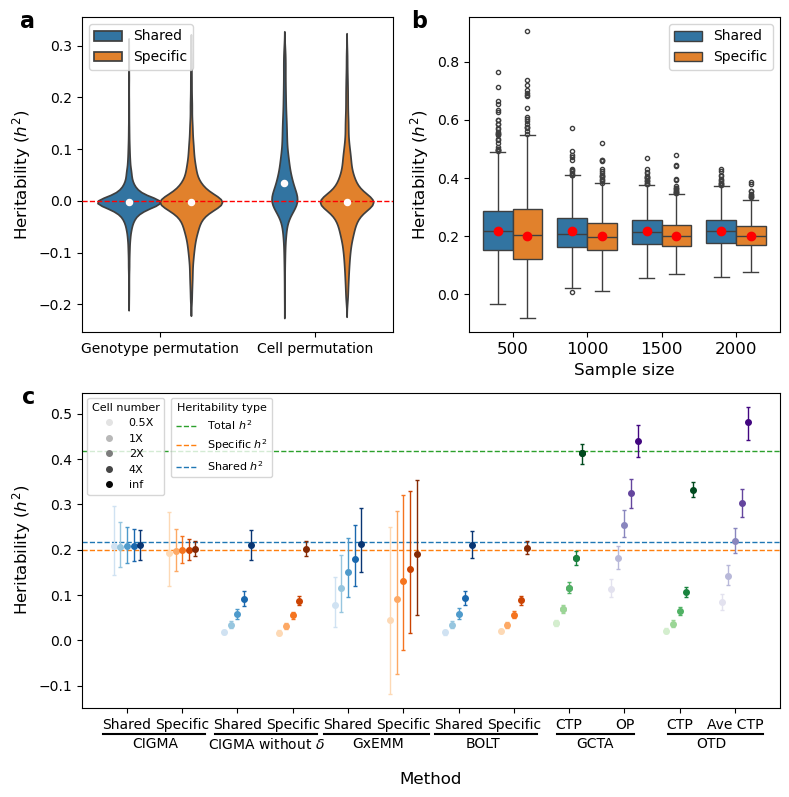

In [8]:
# plot
fs = 12
colors = sns.color_palette()
rng = np.random.default_rng(seed=123)

# Create a gridspec layout
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

# permutation
ax = fig.add_subplot(gs[0, 0])
# ct_df_tmp = ct_df.loc[(ct_df['bio_var'] > 0) & (ct_df['var_shared_h2'] < 100) & (ct_df['var_specific_h2'] < 100), ['shared_h2', 'specific_h2', 'perm']]
ct_df_tmp = ct_df.loc[(ct_df['bio_var'] > 0), ['shared_h2', 'specific_h2', 'perm']]
# geno_df_tmp = geno_df.loc[(geno_df['bio_var'] > 0) & (geno_df['var_shared_h2'] < 100) & (geno_df['var_specific_h2'] < 100), ['shared_h2', 'specific_h2', 'perm']]
geno_df_tmp = geno_df.loc[(geno_df['bio_var'] > 0), ['shared_h2', 'specific_h2', 'perm']]
print(f'Total gene: {ct_df.shape[0]} and {geno_df.shape[0]}; Remained gene: {ct_df_tmp.shape[0]}, {geno_df_tmp.shape[0]}')
print(ct_df_tmp[['shared_h2', 'specific_h2']].describe())
print(geno_df_tmp[['shared_h2', 'specific_h2']].describe())
data2 = pd.concat([ct_df_tmp, geno_df_tmp])  
data2 = data2.melt(id_vars=['perm'], var_name='Type', value_name='var')

# data2['var'] = data2['var'].clip(-.25, .3)  # clip
assert ~(data2['var'].isna().any())
data2_before_filtering = data2.copy()
data2.loc[(data2['var'] < -.2) | (data2['var'] > .3), 'var'] = np.nan  
print(f'removed number of values: {data2["var"].isna().sum()}, {data2["var"].isna().sum() / data2.shape[0]}')
sns.violinplot(data2, x='perm', y='var', hue='Type', order=['Genotype permutation', 'Cell permutation'], ax=ax, inner=None, )
xs = plot.snsbox_get_x(len(data2['perm'].unique()), 2)
dodge = (xs[1] - xs[0])
sns.pointplot(data2_before_filtering, x='perm', y='var', hue='Type', order=['Genotype permutation', 'Cell permutation'], ax=ax, estimator=np.median,
              markers='.', linestyles="none", palette=['snow', 'snow'], dodge=dodge, err_kws={'linewidth':1, 'alpha':0.3}, zorder=10, seed=123)
ax.axhline(0, color='r', linestyle='--', lw=1, zorder=9)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Shared', 'Specific'], fontsize=fs-2, loc='upper left')
ax.set_xlabel('', fontsize=12)
ax.set_ylabel(r'Heritability ($h^2$)', fontsize=12)
fig.text(.05, .99, 'a', fontsize=fs+4, fontweight='bold', va='top', ha='right')

# sample size: unbised estiamtes
tmp_ss_data = ss_data.copy()
ax = fig.add_subplot(gs[0, 1])
# tmp_ss_data['h2'] = tmp_ss_data['h2'].clip(-1.5, 2)  # NOTE: clip
sns.boxplot(data=tmp_ss_data, x='Sample size', y='h2', hue='Category', ax=ax, flierprops=dict(marker='.'))

ax.set_xlabel('Sample size', fontsize=fs)
ax.set_ylabel(r'Heritability ($h^2$)', fontsize=fs)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, fontsize=fs-2)
plt.tick_params(axis='x', labelsize=fs)

xs = plot.snsbox_get_x(len(ss), 2)
ax.scatter(xs, ss_h2, color='r', zorder=10)
fig.text(.54, .99, 'b', fontsize=fs+4, fontweight='bold', va='top', ha='right')


# varying cell number
ax = fig.add_subplot(gs[1, 0:])
tmp_nu_h2_df = nu_h2_df.copy()
offset = 0.12
for i, cat in enumerate(categories):
    if cat in ['GCTA on CTP', 'OTD on CTP']:
        palette = [plt.cm.Greens(i) for i in range(50, 256, 50)] 
    elif cat in ['GCTA on OP', 'OTD on OP']:
        palette = [plt.cm.Purples(i) for i in range(50, 256, 50)] 
    elif cat in ['CIGMA (Shared)', 'CIGMA without nu (Shared)', 'GxEMM (Shared)', 'BOLT (Shared)']:
        palette = [plt.cm.Blues(i) for i in range(50, 256, 50)] 
    elif cat in ['CIGMA (Specific)', 'CIGMA without nu (Specific)', 'GxEMM (Specific)', 'BOLT (Specific)']:
        palette = [plt.cm.Oranges(i) for i in range(50, 256, 50)] 
    for j, cell in enumerate(cell_no):
        tmp = tmp_nu_h2_df.loc[(tmp_nu_h2_df['Category'] == cat) & (tmp_nu_h2_df['Cell number'] == cell)]
        if cat in ['BOLT (Shared)', 'BOLT (Specific)']:
            tmp = tmp.loc[~tmp['h2'].isna()]
        median_h2 = tmp['h2'].median()
        percentile_25 = tmp['h2'].quantile(0.25)
        percentile_75 = tmp['h2'].quantile(0.75)
        sd_h2 = [[median_h2 - percentile_25], [percentile_75 - median_h2]]
        if cat == 'GCTA on CTP':
            tmp_palette = [plt.cm.Grays(i) for i in range(50, 256, 50)] 
            ax.plot([i + (j - 2) * offset], median_h2, linestyle='none',
                        marker='o', markersize=4, color=tmp_palette[j], label=cell)
        ax.errorbar([i + (j - 2) * offset], median_h2, yerr=sd_h2, 
                    fmt='o', capsize=1.5, elinewidth=1, markersize=4, color=palette[j])
            
ax.set_xlabel('\n\nMethod', fontsize=fs)
ax.set_ylabel(r'Heritability ($h^2$)', fontsize=fs)
handles, labels = ax.get_legend_handles_labels()
legend1 = ax.legend(handles=handles, labels=labels, fontsize=fs-4, title_fontsize=fs-4, loc='upper left', title='Cell number')
ax.add_artist(legend1)

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(['Shared', 'Specific', 'Shared', 'Specific', 'Shared', 'Specific', 'Shared', 'Specific', 'CTP', 'OP', 'CTP', 'Ave CTP'])
y = 0.085
line = lines.Line2D([0.135, 0.262], [y, y], color='black', transform=fig.transFigure)
fig.lines.append(line)
ax.text(0.105, -0.115, 'CIGMA', transform=ax.transAxes, fontsize=fs-2, ha='center', va='center')

line = lines.Line2D([0.275, 0.402], [y, y], color='black', transform=fig.transFigure)
fig.lines.append(line)
ax.text(0.265, -0.115, 'CIGMA without $\\delta$', transform=ax.transAxes, fontsize=fs-2, ha='center', va='center')

line = lines.Line2D([0.411, 0.542], [y, y], color='black', transform=fig.transFigure)
fig.lines.append(line)
ax.text(0.425, -0.115, 'GxEMM', transform=ax.transAxes, fontsize=fs-2, ha='center', va='center')

line = lines.Line2D([0.55, 0.678], [y, y], color='black', transform=fig.transFigure)
fig.lines.append(line)
ax.text(0.575, -0.115, 'BOLT', transform=ax.transAxes, fontsize=fs-2, ha='center', va='center')

line = lines.Line2D([0.702, 0.799], [y, y], color='black', transform=fig.transFigure)
fig.lines.append(line)
ax.text(0.735, -0.115, 'GCTA', transform=ax.transAxes, fontsize=fs-2, ha='center', va='center')

line = lines.Line2D([0.841, 0.96], [y, y], color='black', transform=fig.transFigure)
fig.lines.append(line)
ax.text(0.901, -0.115, 'OTD', transform=ax.transAxes, fontsize=fs-2, ha='center', va='center')

line1 = ax.axhline(nu_total_h2[1], ls='--', color=colors[2], label='Total $h^2$', linewidth=1, zorder=-1)
line2 = ax.axhline(nu_specific_h2[1], ls='--', color=colors[1], label='Specific $h^2$', linewidth=1, zorder=-1)
line3 = ax.axhline(nu_shared_h2[1], ls='--', color=colors[0], label='Shared $h^2$', linewidth=1, zorder=-1)
# line4 = ax.axhline(nu_additive_h2[3], ls='--', color=colors[4], label='Additive $h^2$')
legend2 = ax.legend(handles=[line1, line2, line3], fontsize=fs-4, title_fontsize=fs-4, loc='upper left', bbox_to_anchor=(0.12, 1), title='Heritability type', markerscale=0.5)

fig.text(0.05, .52, 'c', fontsize=fs+4, fontweight='bold', va='top', ha='right')
# ax.set_xlim(-.5, 7.5)

fig.tight_layout()

# OTD and BOLT

In [9]:
# # estimated h2
# data = []

# for i, key in enumerate(nu_vcs):
#     tmp = {'Cell number': cell_no[i], 
#            'OTD on demeaned CTP': otd_out[key]['greml_ctp']['V(G)/Vp']['variance'].mean(axis=1),
#            'OTD on Mean CTP': otd_out[key]['greml_op']['V(G)/Vp']['variance'],
#            'BOLT (Shared)': bolt_out[key]['shared_h2'], 
#            'BOLT (Specific)': bolt_out[key]['specific_h2'],
#            }
#     data.append(pd.DataFrame(tmp))

# df = pd.concat(data)
# print('Missing values in BOLT:', df['BOLT (Shared)'].isna().sum() / df.shape[0])
# print('Missing values in BOLT:', df.loc[df['Cell number'] == 'inf', 'BOLT (Shared)'].isna().sum() / df.shape[0])
# df = df.melt(id_vars=['Cell number'], value_vars=['OTD on demeaned CTP', 'OTD on Mean CTP', 'BOLT (Shared)', 'BOLT (Specific)'], 
#              var_name='Category', value_name='h2')

# # plot estimated h2 - OTD and BOLT
# fig, ax = plt.subplots(figsize=(10, 4))
# sns.boxplot(data=df, x='Category', y='h2', hue='Cell number', ax=ax, flierprops=dict(marker='.'))
# ax.set_xlabel('\n\nMethod', fontsize=fs)
# ax.set_ylabel(r'Heritability ($h^2$)', fontsize=fs)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=labels, fontsize=fs-2, title_fontsize=fs-2)
# plt.tick_params(axis='x', labelsize=fs)

# line1 = ax.axhline(nu_total_h2[1], ls='--', color=colors[2], label='Total $h^2$')
# line2 = ax.axhline(nu_specific_h2[1], ls='--', color=colors[1], label='Specific $h^2$')
# line3 = ax.axhline(nu_shared_h2[1], ls='--', color=colors[0], label='Shared $h^2$')
# legend2 = ax.legend(handles=[line1, line2, line3], fontsize=fs-4, title_fontsize=fs-4, loc='upper right', bbox_to_anchor=(0.885, 1), title='Heritability type', markerscale=0.5)


# Specificity

In [10]:
# specificity
# bolt
bolt_data = []
for key in bolt_out.keys():
    tmp = pd.DataFrame({'v': bolt_out[key]['vbar'], 
                        'w': bolt_out[key]['wbar'], 
                        'hom_g2': bolt_out[key]['hom_g2'], 
                        'hom_e2': bolt_out[key]['hom_e2'], 
                        'arg': key})
    bolt_data.append(tmp)
bolt_df = pd.concat(bolt_data, axis=0, ignore_index=True)
bolt_df['g'] = bolt_df['v'] + bolt_df['hom_g2']
bolt_df['specificity'] = bolt_df['v'] / bolt_df['g']
bolt_df['e'] = bolt_df['w'] + bolt_df['hom_e2']
bolt_df['e_specificity'] = bolt_df['w'] / bolt_df['e']
bolt_df['arg'] = bolt_df['arg'].str.split('_').str[-1]
bolt_df.loc[bolt_df['arg'] == '0', 'arg'] = 'inf'
bolt_df.loc[bolt_df['arg'] == '0.205', 'arg'] = '4x'
bolt_df.loc[bolt_df['arg'] == '0.343', 'arg'] = '2x'
bolt_df.loc[bolt_df['arg'] == '0.51', 'arg'] = '1x'
bolt_df.loc[bolt_df['arg'] == '0.676', 'arg'] = '0.5x'
bolt_df['arg'] = bolt_df['arg'].astype('category')

# gxemm
gxemm_out['g'] = gxemm_out['v'] + gxemm_out['sig2g_hom']
gxemm_out['specificity'] = gxemm_out['v'] / gxemm_out['g']
gxemm_out['e'] = gxemm_out['w'] + gxemm_out['sig2e_hom']
gxemm_out['e_specificity'] = gxemm_out['w'] / gxemm_out['e']
gxemm_out['arg'] = gxemm_out['arg'].str.split('_').str[-1]
gxemm_out.loc[gxemm_out['arg'] == '0', 'arg'] = 'inf'
gxemm_out.loc[gxemm_out['arg'] == '0.205', 'arg'] = '4x'
gxemm_out.loc[gxemm_out['arg'] == '0.343', 'arg'] = '2x'
gxemm_out.loc[gxemm_out['arg'] == '0.51', 'arg'] = '1x'
gxemm_out.loc[gxemm_out['arg'] == '0.676', 'arg'] = '0.5x'
gxemm_out['arg'] = gxemm_out['arg'].astype('category')

# cigma
cigma_nu_data = []
print(nu_out.keys())
for key in nu_out.keys():
    tmp = util.read_out(nu_out[key], ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
    tmp['arg'] = key
    cigma_nu_data.append(tmp)
cigma_nu_df = pd.concat(cigma_nu_data, axis=0, ignore_index=True)
cigma_nu_df['g'] = cigma_nu_df['free:v'] + cigma_nu_df['free:hom_g2']
cigma_nu_df['specificity'] = cigma_nu_df['free:v'] / cigma_nu_df['g']
cigma_nu_df['e'] = cigma_nu_df['free:w'] + cigma_nu_df['free:hom_e2']
cigma_nu_df['e_specificity'] = cigma_nu_df['free:w'] / cigma_nu_df['e']
cigma_nu_df['arg'] = cigma_nu_df['arg'].str.split('_').str[-1]
cigma_nu_df.loc[cigma_nu_df['arg'] == '0', 'arg'] = 'inf'
cigma_nu_df.loc[cigma_nu_df['arg'] == '0.205', 'arg'] = '4x'
cigma_nu_df.loc[cigma_nu_df['arg'] == '0.343', 'arg'] = '2x'
cigma_nu_df.loc[cigma_nu_df['arg'] == '0.51', 'arg'] = '1x'
cigma_nu_df.loc[cigma_nu_df['arg'] == '0.676', 'arg'] = '0.5x'
cigma_nu_df['arg'] = cigma_nu_df['arg'].astype('category')


# cigma missing nu
missing_nu_data = []
for key in missing_nu_out.keys():
    tmp = util.read_out(missing_nu_out[key], ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
    tmp['arg'] = key
    missing_nu_data.append(tmp)
missing_nu_df = pd.concat(missing_nu_data, axis=0, ignore_index=True)
missing_nu_df['g'] = missing_nu_df['free:v'] + missing_nu_df['free:hom_g2']
missing_nu_df['specificity'] = missing_nu_df['free:v'] / missing_nu_df['g']
missing_nu_df['e'] = missing_nu_df['free:w'] + missing_nu_df['free:hom_e2']
missing_nu_df['e_specificity'] = missing_nu_df['free:w'] / missing_nu_df['e']
missing_nu_df['arg'] = missing_nu_df['arg'].str.split('_').str[-1]
missing_nu_df.loc[missing_nu_df['arg'] == '0', 'arg'] = 'inf'
missing_nu_df.loc[missing_nu_df['arg'] == '0.205', 'arg'] = '4x'
missing_nu_df.loc[missing_nu_df['arg'] == '0.343', 'arg'] = '2x'
missing_nu_df.loc[missing_nu_df['arg'] == '0.51', 'arg'] = '1x'
missing_nu_df.loc[missing_nu_df['arg'] == '0.676', 'arg'] = '0.5x'
missing_nu_df['arg'] = missing_nu_df['arg'].astype('category')

dict_keys(['0.13_0.13_0.11_0.04_0.08_0.51', '0.086_0.086_0.073_0.026_0.053_0.676', '0.174_0.174_0.148_0.054_0.107_0.343', '0.211_0.211_0.178_0.065_0.13_0.205', '0.266_0.265_0.224_0.082_0.163_0'])


arg
0.5x    0.710846
1x      0.556310
2x      0.500994
4x      0.470185
inf     0.471307
Name: specificity, dtype: float64
arg
0.5x    0.213240
1x      0.310539
2x      0.436646
4x      0.535219
inf     0.716281
Name: e_specificity, dtype: float64


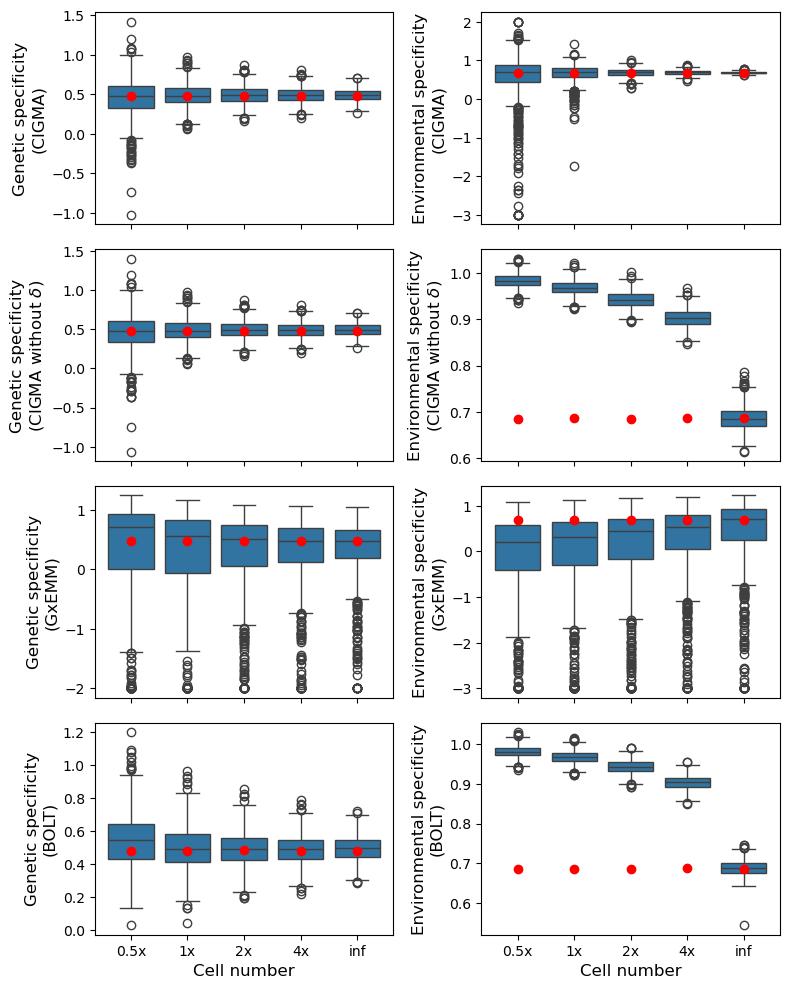

In [11]:
print(gxemm_out.loc[gxemm_out['g'] > 0].groupby(['arg'])['specificity'].median())
print(gxemm_out.loc[gxemm_out['e'] > 0].groupby(['arg'])['e_specificity'].median())

fs = 14
# fig, axes = plt.subplots(4, 2, figsize=(8, 10), sharex=True, sharey='col')
fig, axes = plt.subplots(4, 2, figsize=(8, 10), sharex=True, sharey=False)

for i, df, label in zip(range(4), [cigma_nu_df, missing_nu_df, gxemm_out, bolt_df], ['CIGMA', 'CIGMA without nu', 'GxEMM', 'BOLT']):
    tmp = df.copy()
    tmp['specificity'] = tmp['specificity'].clip(-2, 3)
    tmp['e_specificity'] = tmp['e_specificity'].clip(-3, 2)

    sns.boxplot(data=tmp.loc[tmp['g'] > 0], x='arg', y='specificity', ax=axes[i, 0])
    sns.boxplot(data=tmp.loc[tmp['e'] > 0], x='arg', y='e_specificity', ax=axes[i, 1])

    tmp_simulated = {}
    for key in nu_vcs:
        V, W = nu_Vs[key], nu_Ws[key]
        v, w = np.mean(np.diag(V)), np.mean(np.diag(W))
        hom_g2 = float(key.split('_')[1])
        hom_e2 = float(key.split('_')[2])
        tmp_simulated[key] = {'specificity': v / (hom_g2 + v), 'specificity_e': w / (hom_e2 + w)}
    tmp_simulated = pd.DataFrame(tmp_simulated).T.reset_index().rename(columns={'index': 'arg'})
    tmp_simulated['arg'] = tmp_simulated['arg'].str.split('_').str[-1]
    tmp_simulated.loc[tmp_simulated['arg'] == '0', 'arg'] = 'inf'
    tmp_simulated.loc[tmp_simulated['arg'] == '0.205', 'arg'] = '4x'
    tmp_simulated.loc[tmp_simulated['arg'] == '0.343', 'arg'] = '2x'
    tmp_simulated.loc[tmp_simulated['arg'] == '0.51', 'arg'] = '1x'
    tmp_simulated.loc[tmp_simulated['arg'] == '0.676', 'arg'] = '0.5x'
    tmp_simulated['arg'] = tmp_simulated['arg'].astype('category')
    axes[i, 0].plot(tmp_simulated['arg'], tmp_simulated['specificity'], color='red', marker='o', markersize=6, linestyle='None', zorder=10)
    axes[i, 1].plot(tmp_simulated['arg'], tmp_simulated['specificity_e'], color='red', marker='o', markersize=6, linestyle='None', zorder=10)

    if label == 'CIGMA without nu':
        axes[i, 0].set_ylabel('Genetic specificity\n(CIGMA without $\delta$)', fontsize=fs-2)
        axes[i, 1].set_ylabel('Environmental specificity\n(CIGMA without $\delta$)', fontsize=fs-2)
    else:
        axes[i, 0].set_ylabel(f'Genetic specificity\n({label})', fontsize=fs-2)
        axes[i, 1].set_ylabel(f'Environmental specificity\n({label})', fontsize=fs-2)

axes[-1, 0].set_xlabel('Cell number', fontsize=fs-2)
axes[-1, 1].set_xlabel('Cell number', fontsize=fs-2)

fig.tight_layout()

In [12]:
# GCTA decreased precision in h2 estimation when using more cells
key1 = '0.13_0.13_0.11_0.04_0.08_0.51'
key2 = '0.266_0.265_0.224_0.082_0.163_0'
print('1X')
print(gcta_out[key1]['greml_op']['V(G)']['variance'].mean())
print(gcta_out[key1]['greml_op']['V(G)']['se'].mean())
print((gcta_out[key1]['greml_op']['V(G)']['se'] / gcta_out[key1]['greml_op']['V(G)']['variance']).mean())

print(gcta_out[key1]['greml_op']['V(e)']['variance'].mean())
print(gcta_out[key1]['greml_op']['V(e)']['se'].mean())
print((gcta_out[key1]['greml_op']['V(e)']['se'] / gcta_out[key1]['greml_op']['V(e)']['variance']).mean())

print(gcta_out[key1]['greml_op']['V(G)/Vp']['se'].mean())

print('inf')
print(gcta_out[key2]['greml_op']['V(G)']['variance'].mean())
print(gcta_out[key2]['greml_op']['V(G)']['se'].mean())
print((gcta_out[key2]['greml_op']['V(G)']['se'] / gcta_out[key2]['greml_op']['V(G)']['variance']).mean())
print(gcta_out[key2]['greml_op']['V(e)']['variance'].mean())
print(gcta_out[key2]['greml_op']['V(e)']['se'].mean())
print((gcta_out[key2]['greml_op']['V(e)']['se'] / gcta_out[key2]['greml_op']['V(e)']['variance']).mean())
print(gcta_out[key2]['greml_op']['V(G)/Vp']['se'].mean())

1X
0.159799666
0.033391408
0.21293497885527
0.708864928
0.033468545999999995
0.04721441628681698
0.032608801
inf
0.323786089
0.052113978000000005
0.1617398484351566
0.40600825500000004
0.019180169999999996
0.04724085993480772
0.04150928599999999


# Supp fig: unbiased + power

In [13]:
# par
hom_g2 = Hom_g2
hom_e2 = Hom_e2

# sample size
ss_real_shared_h2 = []
ss_real_specific_h2 = []
# tmp_ss_data = []
ss_power = {'Sample size': [], 'True Positive rate': [], 'False Positive rate': []}
ngene = len(list(ss_out.values())[0]['gene'])

for key in ss_out.keys():
    V, W = ss_Vs[key], ss_Ws[key]
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    ss_real_shared_h2.append(hom_g2 / (hom_g2 + V_bar + hom_e2 + W_bar))
    ss_real_specific_h2.append(V_bar / (hom_g2 + V_bar + hom_e2 + W_bar))
    # tmp = {'Sample size': int(key), 'Shared': ss_out[key]['free']['shared_h2'], 'Specific': ss_out[key]['free']['specific_h2']}
    # tmp_ss_data.append(pd.DataFrame(tmp))
    ss_power['Sample size'].append(int(key))
    ss_power['True Positive rate'].append((ss_out[key]['wald']['free']['V'] < 0.05).sum() / ngene)
    ss_power['False Positive rate'].append((hom_ss_out[key]['wald']['free']['V'] < 0.05).sum() / ngene)

ss_real_h2 = np.array([ss_real_shared_h2, ss_real_specific_h2]).T.flatten()
# ss_df = pd.concat(tmp_ss_data)
# ss_df = ss_df.melt(id_vars=['Sample size'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')
ss_df = ss_data.copy()
ss_power = pd.DataFrame(ss_power).sort_values(by='Sample size')


# cell type proportion 
ctp_out = np.load('../../analysis/sim/free/L_20_nL_80/AGGa.he.npy', allow_pickle=True).item()
ctp_hom_out = np.load('../../analysis/sim/hom/L_20_nL_80/AGGa.he.npy', allow_pickle=True).item()
ctp_Vs = np.load('../../analysis/sim/free/AGGa.true_V.npy', allow_pickle=True).item()
ctp_Ws = np.load('../../analysis/sim/free/AGGa.true_W.npy', allow_pickle=True).item()
ctp_real_shared_h2 = []
ctp_real_specific_h2 = []
ctp_data = []
ctp_power = {'First cell type proportion': [], 'True Positive rate': [], 'False Positive rate': []}
main_ct_props = []

for key in ctp_out.keys():
    a = np.array(key.split('_')).astype('int')
    main_ct_prop = a[0] / np.sum(a)
    main_ct_props.append(main_ct_prop)
    V, W = ctp_Vs[key], ctp_Ws[key]
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    ctp_real_shared_h2.append(hom_g2 / (hom_g2 + V_bar + hom_e2 + W_bar))
    ctp_real_specific_h2.append(V_bar / (hom_g2 + V_bar + hom_e2 + W_bar))
    tmp = {'First cell type proportion': main_ct_prop, 'Shared': ctp_out[key]['free']['shared_h2'], 'Specific': ctp_out[key]['free']['specific_h2']}
    ctp_data.append(pd.DataFrame(tmp))
    ctp_power['First cell type proportion'].append(main_ct_prop)
    ctp_power['True Positive rate'].append((ctp_out[key]['wald']['free']['V'] < 0.05).sum() / ngene)
    ctp_power['False Positive rate'].append((ctp_hom_out[key]['wald']['free']['V'] < 0.05).sum() / ngene)

## order h2
print(main_ct_props, ctp_real_shared_h2, ctp_real_specific_h2)
ctp_real_shared_h2 = np.array(ctp_real_shared_h2)[np.argsort(main_ct_props)]
ctp_real_specific_h2 = np.array(ctp_real_specific_h2)[np.argsort(main_ct_props)]

ctp_real_h2 = np.array([ctp_real_shared_h2, ctp_real_specific_h2]).T.flatten()
ctp_df = pd.concat(ctp_data)
ctp_df = ctp_df.melt(id_vars=['First cell type proportion'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')
ctp_power = pd.DataFrame(ctp_power).sort_values(by='First cell type proportion')


# specificity
spec_out = np.load('../../analysis/sim/free/L_20_nL_80/AGGvc.he.npy', allow_pickle=True).item()
spec_Vs = np.load('../../analysis/sim/free/AGGvc.true_V.npy', allow_pickle=True).item()
spec_Ws = np.load('../../analysis/sim/free/AGGvc.true_W.npy', allow_pickle=True).item()
spec_real_shared_h2 = []
spec_real_specific_h2 = []
spec_data = []
spec_power = {'Specificity': [], 'True Positive rate': []}
specificitys = []

for key in spec_out.keys():
    vc = np.array(key.split('_')).astype('float')
    spec_hom_g2, spec_hom_e2 = vc[1], vc[2]
    V, W = spec_Vs[key], spec_Ws[key]
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    specificity = V_bar / (spec_hom_g2 + V_bar)
    specificitys.append(specificity)
    spec_real_shared_h2.append(spec_hom_g2 / (spec_hom_g2 + V_bar + spec_hom_e2 + W_bar))
    spec_real_specific_h2.append(V_bar / (spec_hom_g2 + V_bar + spec_hom_e2 + W_bar))
    tmp = {'Specificity': specificity, 'Shared': spec_out[key]['free']['shared_h2'], 'Specific': spec_out[key]['free']['specific_h2']}
    spec_data.append(pd.DataFrame(tmp))
    spec_power['Specificity'].append(specificity)
    spec_power['True Positive rate'].append((spec_out[key]['wald']['free']['V'] < 0.05).sum() / ngene)

## order h2
spec_real_shared_h2 = np.array(spec_real_shared_h2)[np.argsort(specificitys)]
spec_real_specific_h2 = np.array(spec_real_specific_h2)[np.argsort(specificitys)]

spec_real_h2 = np.array([spec_real_shared_h2, spec_real_specific_h2]).T.flatten()
spec_df = pd.concat(spec_data)
spec_df = spec_df.melt(id_vars=['Specificity'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')
spec_power = pd.DataFrame(spec_power).sort_values(by='Specificity')


# V
V_out = np.load('../../analysis/sim/free/L_20_nL_80/AGGV_diag.he.npy', allow_pickle=True).item()
V_Vs = np.load('../../analysis/sim/free/AGGV_diag.true_V.npy', allow_pickle=True).item()
V_Ws = np.load('../../analysis/sim/free/AGGV_diag.true_W.npy', allow_pickle=True).item()
V_real_shared_h2 = []
V_real_specific_h2 = []
V_data = []
V_power = {'V1': [], 'True Positive rate': []}
V1s = []

for key in V_out.keys():
    V_ratio = key.split('_')
    V, W = V_Vs[key], V_Ws[key]
    V1s.append(float(V_ratio[0]))
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    V_real_shared_h2.append(hom_g2 / (hom_g2 + V_bar + hom_e2 + W_bar))
    V_real_specific_h2.append(V_bar / (hom_g2 + V_bar + hom_e2 + W_bar))
    tmp = {'V1': float(V_ratio[0]), 'Shared': V_out[key]['free']['shared_h2'], 'Specific': V_out[key]['free']['specific_h2']}
    V_data.append(pd.DataFrame(tmp))
    V_power['V1'].append(float(V_ratio[0]))
    V_power['True Positive rate'].append((V_out[key]['wald']['free']['V'] < 0.05).sum() / ngene)

## order h2
V_real_shared_h2 = np.array(V_real_shared_h2)[np.argsort(V1s)]
V_real_specific_h2 = np.array(V_real_specific_h2)[np.argsort(V1s)]

V_real_h2 = np.array([V_real_shared_h2, V_real_specific_h2]).T.flatten()
V_df = pd.concat(V_data)
V_df = V_df.melt(id_vars=['V1'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')
V_power = pd.DataFrame(V_power).sort_values('V1')

# cell type number
ct2_out = np.load('../../analysis/sim/free21/L_20_nL_80/AGGss.he.npy', allow_pickle=True).item()
ct8_out = np.load('../../analysis/sim/free22/L_20_nL_80/AGGss.he.npy', allow_pickle=True).item()
ct2_hom_out = np.load('../../analysis/sim/hom21/L_20_nL_80/AGGss.he.npy', allow_pickle=True).item()
ct8_hom_out = np.load('../../analysis/sim/hom22/L_20_nL_80/AGGss.he.npy', allow_pickle=True).item()
ct2_Vs = np.load('../../analysis/sim/free21/AGGss.true_V.npy', allow_pickle=True).item()
ct2_Ws = np.load('../../analysis/sim/free21/AGGss.true_W.npy', allow_pickle=True).item()
ct8_Vs = np.load('../../analysis/sim/free22/AGGss.true_V.npy', allow_pickle=True).item()
ct8_Ws = np.load('../../analysis/sim/free22/AGGss.true_W.npy', allow_pickle=True).item()
ctn_real_shared_h2 = []
ctn_real_specific_h2 = []
ctn_data = []
ctn_power = {'Cell type number': [], 'True Positive rate': [], 'False Positive rate': []}

for C, hom_out, out, Vs, Ws in zip([2, 4, 8], [ct2_hom_out, hom_ss_out, ct8_hom_out], [ct2_out, ss_out, ct8_out], [ct2_Vs, ss_Vs, ct8_Vs], [ct2_Ws, ss_Ws, ct8_Ws]):
    V, W = Vs['1000'], Ws['1000']
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    ctn_real_shared_h2.append(hom_g2 / (hom_g2 + V_bar + hom_e2 + W_bar))
    ctn_real_specific_h2.append(V_bar / (hom_g2 + V_bar + hom_e2 + W_bar))
    tmp = {'Cell type number': C, 'Shared': out['1000']['free']['shared_h2'], 'Specific': out['1000']['free']['specific_h2']}
    ctn_data.append(pd.DataFrame(tmp))
    ctn_power['Cell type number'].append(C)
    ctn_power['True Positive rate'].append((out['1000']['wald']['free']['V'] < 0.05).sum() / ngene)
    ctn_power['False Positive rate'].append((hom_out['1000']['wald']['free']['V'] < 0.05).sum() / ngene)

ctn_real_h2 = np.array([ctn_real_shared_h2, ctn_real_specific_h2]).T.flatten()
ctn_df = pd.concat(ctn_data)
ctn_df = ctn_df.melt(id_vars=['Cell type number'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')
ctn_power = pd.DataFrame(ctn_power).sort_values('Cell type number')


# cell number
nu_out = np.load('../../analysis/sim/free3/L_20_nL_80/AGGvc.he.npy', allow_pickle=True).item()
nu_hom_out = np.load('../../analysis/sim/hom3/L_20_nL_80/AGGvc.he.npy', allow_pickle=True).item()
nu_Vs = np.load('../../analysis/sim/free3/AGGvc.true_V.npy', allow_pickle=True).item()
nu_Ws = np.load('../../analysis/sim/free3/AGGvc.true_W.npy', allow_pickle=True).item()
nu_real_shared_h2 = []
nu_real_specific_h2 = []
nu_data = []
nu_tpr = {'Cell number': [], 'True Positive rate': []}
nu_fpr = {'Cell number': [], 'False Positive rate': []}

# santiy check cell number
hom_nu_vcs = ['0.084_0.084_0.071_0_0.052_0.709', '0.13_0.13_0.11_0_0.08_0.55', 
              '0.179_0.179_0.152_0_0.11_0.38', '0.221_0.221_0.187_0_0.136_0.235', '0.289_0.289_0.244_0_0.178_0']
base_nu_vc = np.array(hom_nu_vcs[1].split('_'), dtype=float)
for x, nu_vc in zip(NS, hom_nu_vcs):
    nu = base_nu_vc[5] / x
    tmp = base_nu_vc.copy()
    tmp[5] = nu
    assert np.allclose(tmp / tmp.sum(), np.array(nu_vc.split('_'), dtype=float), rtol=0, atol=0.002)

for i, key in enumerate(Nu_vcs):
    n_label = Cell_no[i]
    vc = np.array(key.split('_')).astype('float')
    nu_hom_g2, nu_hom_e2, nu = vc[1], vc[2], vc[-1]
    V, W = nu_Vs[key], nu_Ws[key]
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    nu_real_shared_h2.append(nu_hom_g2 / (nu_hom_g2 + V_bar + nu_hom_e2 + W_bar))
    nu_real_specific_h2.append(V_bar / (nu_hom_g2 + V_bar + nu_hom_e2 + W_bar))
    tmp = {'Cell number': n_label, 'Shared': nu_out[key]['free']['shared_h2'], 'Specific': nu_out[key]['free']['specific_h2']}
    nu_data.append(pd.DataFrame(tmp))
    nu_tpr['Cell number'].append(n_label)
    nu_tpr['True Positive rate'].append((nu_out[key]['wald']['free']['V'] < 0.05).sum() / ngene)


for i, key in enumerate(hom_nu_vcs):
    n_label = Cell_no[i]
    vc = np.array(key.split('_')).astype('float')
    nu_fpr['Cell number'].append(n_label)
    nu_fpr['False Positive rate'].append((nu_hom_out[key]['wald']['free']['V'] < 0.05).sum() / ngene)

nu_real_h2 = np.array([nu_real_shared_h2, nu_real_specific_h2]).T.flatten()
nu_df = pd.concat(nu_data)
nu_df = nu_df.melt(id_vars=['Cell number'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')
nu_tpr = pd.DataFrame(nu_tpr)
nu_fpr = pd.DataFrame(nu_fpr)
nu_power = nu_tpr.merge(nu_fpr, on='Cell number')
nu_power = nu_power.sort_values('Cell number')

# noisy nu
noisy_nu_out = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/out.he.noisy_nu.npy', allow_pickle=True).item()
noisy_nu_hom_out = np.load('../../analysis/sim/hom/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0_0.08_0.55_beta~8_4_2_1_V_diag~0_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/out.he.noisy_nu.npy', allow_pickle=True).item()

nu_noises = noisy_nu_out.keys()
nu_noises = sorted(nu_noises)
assert np.all(np.unique(nu_noises) == np.unique(list(noisy_nu_hom_out.keys())))

noisy_nu_V = np.load('../../analysis/sim/free/AGGss.true_V.npy', allow_pickle=True).item()['1000']
noisy_nu_W = np.load('../../analysis/sim/free/AGGss.true_W.npy', allow_pickle=True).item()['1000']
noisy_nu_V_bar = np.mean(np.diag(noisy_nu_V))
noisy_nu_W_bar = np.mean(np.diag(noisy_nu_W))
noisy_nu_real_shared_h2 = hom_g2 / (hom_g2 + noisy_nu_V_bar + hom_e2 + noisy_nu_W_bar)
noisy_nu_real_specific_h2 = noisy_nu_V_bar / (hom_g2 + noisy_nu_V_bar + hom_e2 + noisy_nu_W_bar)
noisy_nu_data = []
noisy_nu_power = {'Noise': [], 'True Positive rate': [], 'False Positive rate': []}

for noise, hom_out, out in zip([0] + nu_noises, [hom_ss_out['1000']] + [noisy_nu_hom_out[key] for key in nu_noises], [ss_out['1000']] + [noisy_nu_out[key] for key in nu_noises]):
    tmp = {'Noise': str(noise), 'Shared': out['free']['shared_h2'], 'Specific': out['free']['specific_h2']}
    noisy_nu_data.append(pd.DataFrame(tmp))
    noisy_nu_power['Noise'].append(str(noise))
    noisy_nu_power['True Positive rate'].append((out['wald']['free']['V'] < 0.05).sum() / ngene)
    noisy_nu_power['False Positive rate'].append((hom_out['wald']['free']['V'] < 0.05).sum() / ngene)

noisy_nu_real_h2 = np.array([[noisy_nu_real_shared_h2] * 4, [noisy_nu_real_specific_h2] * 4]).T.flatten()
print(noisy_nu_real_h2)
noisy_nu_df = pd.concat(noisy_nu_data)
noisy_nu_df = noisy_nu_df.melt(id_vars=['Noise'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')
noisy_nu_power = pd.DataFrame(noisy_nu_power).sort_values(by='Noise')

# reml
reml_nu = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/out.reml.noisy_nu.npy', allow_pickle=True).item()
reml_noisy_nu_data = []

for noise, out in zip([0] + nu_noises, [ss_out['1000']] + [reml_nu[key] for key in nu_noises]):
    tmp_df = util.read_out(out, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
    shared_h2 = tmp_df['free:hom_g2'] / (tmp_df['free:hom_g2'] + tmp_df['free:v'] + tmp_df['free:hom_e2'] + tmp_df['free:w'])
    specific_h2 = tmp_df['free:v'] / (tmp_df['free:hom_g2'] + tmp_df['free:v'] + tmp_df['free:hom_e2'] + tmp_df['free:w'])
    tmp = {'Noise': str(noise), 'Shared': shared_h2, 'Specific': specific_h2}
    reml_noisy_nu_data.append(pd.DataFrame(tmp))

reml_noisy_nu_df = pd.concat(reml_noisy_nu_data)
reml_noisy_nu_df = reml_noisy_nu_df.melt(id_vars=['Noise'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')


[np.float64(0.25), np.float64(0.5714285714285714), np.float64(0.4), np.float64(0.14285714285714285)] [np.float64(0.21666666666666667), np.float64(0.25), np.float64(0.221326164874552), np.float64(0.22569444444444442)] [np.float64(0.2), np.float64(0.17948717948717946), np.float64(0.1971326164874552), np.float64(0.19444444444444445)]
[0.21666667 0.2        0.21666667 0.2        0.21666667 0.2
 0.21666667 0.2       ]


[2026-02-07 19:59:33 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-07 19:59:33 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-07 19:59:33 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-07 19:59:33 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-07 19:59:33 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

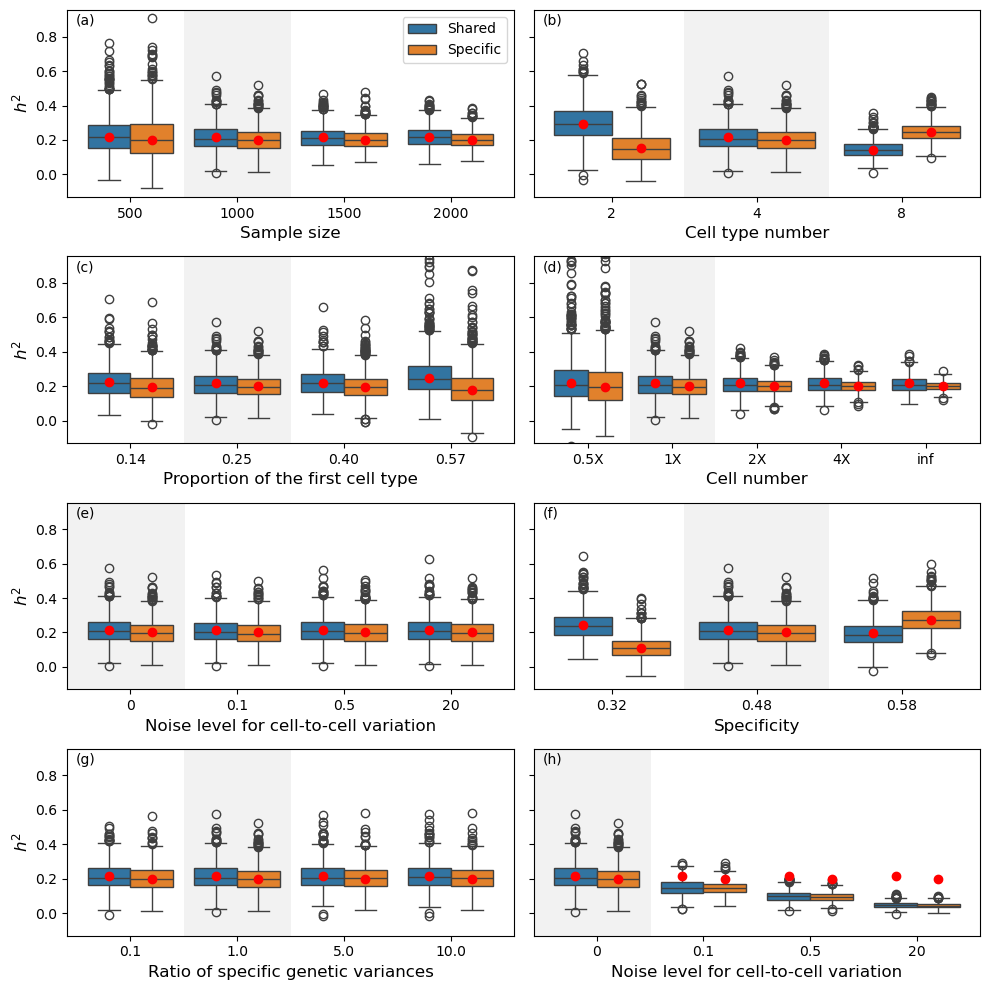

In [14]:
# fig: estiamted h2
fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharey=True)
# amin, amax = -1.5, 2

# sample size
ax = axes[0, 0]
# ss_df['h2'] = ss_df['h2'].clip(amin, amax)  # clip
sns.boxplot(data=ss_df, x='Sample size', y='h2', hue='Category', ax=ax)

ax.set_xlabel('Sample size', fontsize=12)
ax.set_ylabel(r'$h^2$', fontsize=12)
ax.legend()
ax.tick_params(axis='both', labelsize=10)

xs = plot.snsbox_get_x(ss_df['Sample size'].nunique(), 2)
ax.scatter(xs, ss_real_h2, color='r', zorder=10)

ax.text(0.02, 0.92, "(a)", transform=ax.transAxes)
ymin, ymax = ax.get_ylim()
rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
ax.add_patch(rectangle)
ax.set_ylim((ymin, ymax))

# cell type number
ax = axes[0, 1]
# ctn_df['h2'] = ctn_df['h2'].clip(amin, amax)
sns.boxplot(data=ctn_df, x='Cell type number', y='h2', hue='Category', ax=ax)

ax.set_xlabel("Cell type number", fontsize=12)
ax.legend().set_visible(False)
ax.tick_params(axis='both', labelsize=10)

xs = plot.snsbox_get_x(ctn_df['Cell type number'].nunique(), 2)
ax.scatter(xs, ctn_real_h2, color='r', zorder=10)

ax.text(0.02, 0.92, "(b)", transform=ax.transAxes)
rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
ax.add_patch(rectangle)

# cell type proportion
ax = axes[1, 0]
# ctp_df['h2'] = ctp_df['h2'].clip(amin, amax)
sns.boxplot(data=ctp_df, x='First cell type proportion', y='h2', hue='Category', ax=ax)

ax.set_xlabel('Proportion of the first cell type', fontsize=12)
ax.set_ylabel(r'$h^2$', fontsize=12)
old_labels = [label.get_text() for label in ax.get_xticklabels()]
new_labels = [f"{float(label):.2f}" for label in old_labels]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(new_labels)
ax.legend().set_visible(False)
ax.tick_params(axis='both', labelsize=10)

xs = plot.snsbox_get_x(ctp_df['First cell type proportion'].nunique(), 2)
ax.scatter(xs, ctp_real_h2, color='r', zorder=10)

ax.text(0.02, 0.92, "(c)", transform=ax.transAxes)
rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
ax.add_patch(rectangle)


# cell number
ax = axes[1, 1]
tmp_nu_df = nu_df.copy()
# tmp_nu_df['h2'] = tmp_nu_df['h2'].clip(amin, amax)
sns.boxplot(data=tmp_nu_df, x='Cell number', y='h2', hue='Category', order=np.sort(nu_df['Cell number'].unique()), ax=ax)

ax.set_xlabel("Cell number", fontsize=12)
ax.legend().set_visible(False)
ax.tick_params(axis='both', labelsize=10)

# print(n_df['Cell number'].unique())
xs = plot.snsbox_get_x(tmp_nu_df['Cell number'].nunique(), 2)
ax.scatter(xs, nu_real_h2, color='r', zorder=10)

ax.text(0.02, 0.92, "(d)", transform=ax.transAxes)
xmin, xmax = ax.get_xlim()
rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
ax.add_patch(rectangle)

# nu noise
ax = axes[2, 0]
tmp_noisy_nu_df = noisy_nu_df.copy()
# tmp_noisy_nu_df['h2'] = tmp_noisy_nu_df['h2'].clip(amin, amax)  # clip
sns.boxplot(data=tmp_noisy_nu_df, x='Noise', y='h2', hue='Category', ax=ax)

ax.set_xlabel('Noise level for cell-to-cell variation', fontsize=12)
ax.set_ylabel(r'$h^2$', fontsize=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend().set_visible(False)
ax.tick_params(axis='both', labelsize=10)

xs = plot.snsbox_get_x(tmp_noisy_nu_df['Noise'].nunique(), 2)
ax.scatter(xs, noisy_nu_real_h2, color='r', zorder=10)

ax.text(0.02, 0.92, "(e)", transform=ax.transAxes)
xmin, xmax = ax.get_xlim()
rectangle = patches.Rectangle((xmin, ymin), (xs[2] - xs[0] + .1), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
ax.add_patch(rectangle)


# specificity
ax = axes[2, 1]
# spec_df['h2'] = spec_df['h2'].clip(amin, amax)
sns.boxplot(data=spec_df, x='Specificity', y='h2', hue='Category', ax=ax)

ax.set_xlabel('Specificity', fontsize=12)
old_labels = [label.get_text() for label in ax.get_xticklabels()]
new_labels = [f"{float(label):.2f}" for label in old_labels]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(new_labels)
ax.legend().set_visible(False)
ax.tick_params(axis='both', labelsize=10)

xs = plot.snsbox_get_x(spec_df['Specificity'].nunique(), 2)
ax.scatter(xs, spec_real_h2, color='r', zorder=10)

ax.text(0.02, 0.92, "(f)", transform=ax.transAxes)
rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
ax.add_patch(rectangle)


# V
ax = axes[3, 0]
# V_df['h2'] = V_df['h2'].clip(amin, amax)
sns.boxplot(data=V_df, x='V1', y='h2', hue='Category', ax=ax)

ax.set_xlabel("Ratio of specific genetic variances", fontsize=12)
ax.set_ylabel(r'$h^2$', fontsize=12)
old_labels = [label.get_text() for label in ax.get_xticklabels()]
new_labels = [f"{float(label):.1f}" for label in old_labels]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(new_labels)
ax.legend().set_visible(False)
ax.tick_params(axis='both', labelsize=10)

xs = plot.snsbox_get_x(V_df['V1'].nunique(), 2)
ax.scatter(xs, V_real_h2, color='r', zorder=10)

ax.text(0.02, 0.92, "(g)", transform=ax.transAxes)
rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
ax.add_patch(rectangle)

# nu noise: reml
ax = axes[3, 1]
tmp_noisy_nu_df = reml_noisy_nu_df.copy()
# tmp_noisy_nu_df['h2'] = tmp_noisy_nu_df['h2'].clip(amin, amax)  # clip
sns.boxplot(data=tmp_noisy_nu_df, x='Noise', y='h2', hue='Category', ax=ax)

ax.set_xlabel('Noise level for cell-to-cell variation', fontsize=12)
ax.set_ylabel(r'$h^2$', fontsize=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend().set_visible(False)
ax.tick_params(axis='both', labelsize=10)

xs = plot.snsbox_get_x(tmp_noisy_nu_df['Noise'].nunique(), 2)
ax.scatter(xs, noisy_nu_real_h2, color='r', zorder=10)

ax.text(0.02, 0.92, "(h)", transform=ax.transAxes)
xmin, xmax = ax.get_xlim()
rectangle = patches.Rectangle((xmin, ymin), (xs[2] - xs[0] + .1), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
ax.add_patch(rectangle)

fig.tight_layout()

[2026-02-07 20:04:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-07 20:04:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-07 20:04:04 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-07 20:04:04 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-07 20:04:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

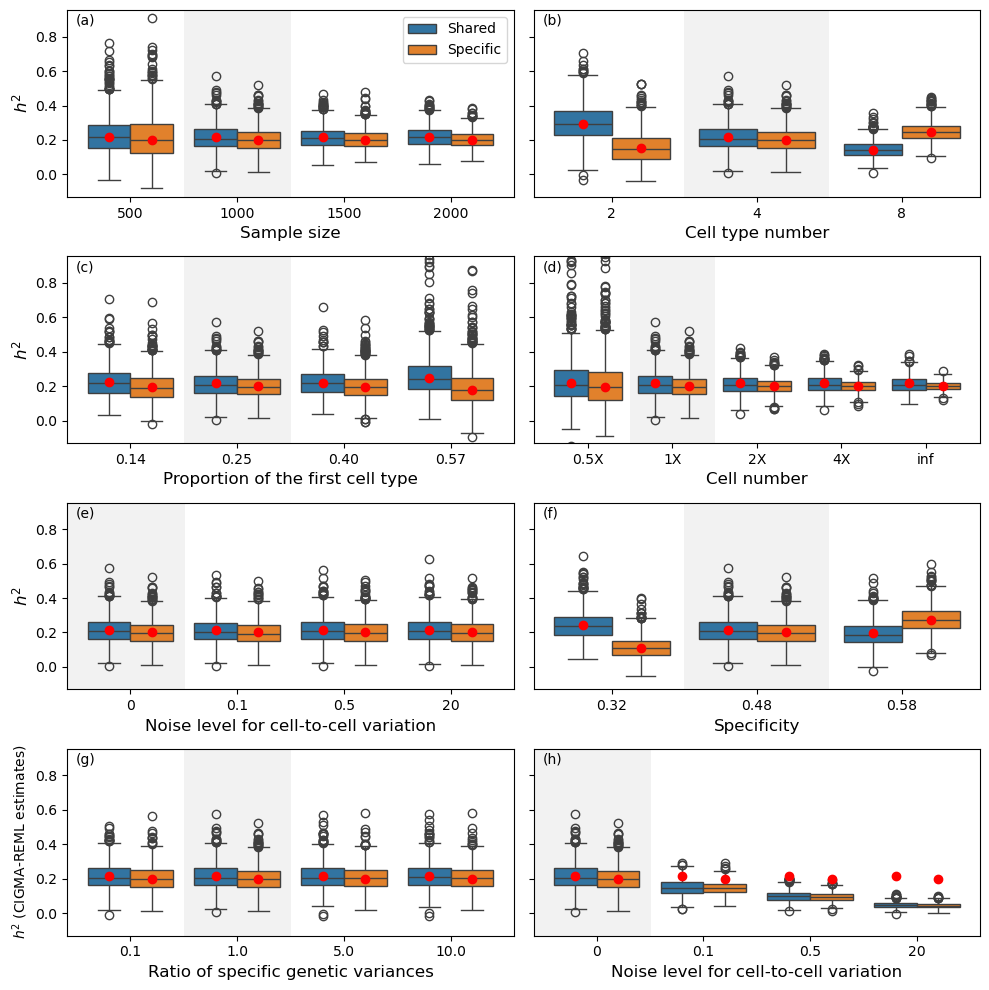

In [ ]:
# # fig: estiamted h2
# fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharey=True)
# # amin, amax = -1.5, 2

# # sample size
# ax = axes[0, 0]
# # ss_df['h2'] = ss_df['h2'].clip(amin, amax)  # clip
# sns.boxplot(data=ss_df, x='Sample size', y='h2', hue='Category', ax=ax)

# ax.set_xlabel('Sample size', fontsize=12)
# ax.set_ylabel(r'$h^2$', fontsize=12)
# ax.legend()
# ax.tick_params(axis='both', labelsize=10)

# xs = plot.snsbox_get_x(ss_df['Sample size'].nunique(), 2)
# ax.scatter(xs, ss_real_h2, color='r', zorder=10)

# ax.text(0.02, 0.92, "(a)", transform=ax.transAxes)
# ymin, ymax = ax.get_ylim()
# rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
# ax.add_patch(rectangle)
# ax.set_ylim((ymin, ymax))

# # cell type number
# ax = axes[0, 1]
# # ctn_df['h2'] = ctn_df['h2'].clip(amin, amax)
# sns.boxplot(data=ctn_df, x='Cell type number', y='h2', hue='Category', ax=ax)

# ax.set_xlabel("Cell type number", fontsize=12)
# ax.legend().set_visible(False)
# ax.tick_params(axis='both', labelsize=10)

# xs = plot.snsbox_get_x(ctn_df['Cell type number'].nunique(), 2)
# ax.scatter(xs, ctn_real_h2, color='r', zorder=10)

# ax.text(0.02, 0.92, "(b)", transform=ax.transAxes)
# rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
# ax.add_patch(rectangle)

# # cell type proportion
# ax = axes[1, 0]
# # ctp_df['h2'] = ctp_df['h2'].clip(amin, amax)
# sns.boxplot(data=ctp_df, x='First cell type proportion', y='h2', hue='Category', ax=ax)

# ax.set_xlabel('Proportion of the first cell type', fontsize=12)
# ax.set_ylabel(r'$h^2$', fontsize=12)
# old_labels = [label.get_text() for label in ax.get_xticklabels()]
# new_labels = [f"{float(label):.2f}" for label in old_labels]
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(new_labels)
# ax.legend().set_visible(False)
# ax.tick_params(axis='both', labelsize=10)

# xs = plot.snsbox_get_x(ctp_df['First cell type proportion'].nunique(), 2)
# ax.scatter(xs, ctp_real_h2, color='r', zorder=10)

# ax.text(0.02, 0.92, "(c)", transform=ax.transAxes)
# rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
# ax.add_patch(rectangle)


# # cell number
# ax = axes[1, 1]
# tmp_nu_df = nu_df.copy()
# # tmp_nu_df['h2'] = tmp_nu_df['h2'].clip(amin, amax)
# sns.boxplot(data=tmp_nu_df, x='Cell number', y='h2', hue='Category', order=np.sort(nu_df['Cell number'].unique()), ax=ax)

# ax.set_xlabel("Cell number", fontsize=12)
# ax.legend().set_visible(False)
# ax.tick_params(axis='both', labelsize=10)

# # print(n_df['Cell number'].unique())
# xs = plot.snsbox_get_x(tmp_nu_df['Cell number'].nunique(), 2)
# ax.scatter(xs, nu_real_h2, color='r', zorder=10)

# ax.text(0.02, 0.92, "(d)", transform=ax.transAxes)
# xmin, xmax = ax.get_xlim()
# rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
# ax.add_patch(rectangle)

# # nu noise
# ax = axes[2, 0]
# tmp_noisy_nu_df = noisy_nu_df.copy()
# # tmp_noisy_nu_df['h2'] = tmp_noisy_nu_df['h2'].clip(amin, amax)  # clip
# sns.boxplot(data=tmp_noisy_nu_df, x='Noise', y='h2', hue='Category', ax=ax)

# ax.set_xlabel('Noise level for cell-to-cell variation', fontsize=12)
# ax.set_ylabel(r'$h^2$', fontsize=12)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend().set_visible(False)
# ax.tick_params(axis='both', labelsize=10)

# xs = plot.snsbox_get_x(tmp_noisy_nu_df['Noise'].nunique(), 2)
# ax.scatter(xs, noisy_nu_real_h2, color='r', zorder=10)

# ax.text(0.02, 0.92, "(e)", transform=ax.transAxes)
# xmin, xmax = ax.get_xlim()
# rectangle = patches.Rectangle((xmin, ymin), (xs[2] - xs[0] + .1), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
# ax.add_patch(rectangle)


# # specificity
# ax = axes[2, 1]
# # spec_df['h2'] = spec_df['h2'].clip(amin, amax)
# sns.boxplot(data=spec_df, x='Specificity', y='h2', hue='Category', ax=ax)

# ax.set_xlabel('Specificity', fontsize=12)
# old_labels = [label.get_text() for label in ax.get_xticklabels()]
# new_labels = [f"{float(label):.2f}" for label in old_labels]
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(new_labels)
# ax.legend().set_visible(False)
# ax.tick_params(axis='both', labelsize=10)

# xs = plot.snsbox_get_x(spec_df['Specificity'].nunique(), 2)
# ax.scatter(xs, spec_real_h2, color='r', zorder=10)

# ax.text(0.02, 0.92, "(f)", transform=ax.transAxes)
# rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
# ax.add_patch(rectangle)


# # V
# ax = axes[3, 0]
# # V_df['h2'] = V_df['h2'].clip(amin, amax)
# sns.boxplot(data=V_df, x='V1', y='h2', hue='Category', ax=ax)

# ax.set_xlabel("Ratio of specific genetic variances", fontsize=12)
# ax.set_ylabel(r'$h^2$ (CIGMA-REML estimates)', fontsize=10)
# old_labels = [label.get_text() for label in ax.get_xticklabels()]
# new_labels = [f"{float(label):.1f}" for label in old_labels]
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(new_labels)
# ax.legend().set_visible(False)
# ax.tick_params(axis='both', labelsize=10)

# xs = plot.snsbox_get_x(V_df['V1'].nunique(), 2)
# ax.scatter(xs, V_real_h2, color='r', zorder=10)

# ax.text(0.02, 0.92, "(g)", transform=ax.transAxes)
# rectangle = patches.Rectangle(((xs[1] + xs[2]) / 2, ymin), (xs[3] - xs[1]), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
# ax.add_patch(rectangle)

# # nu noise: reml
# ax = axes[3, 1]
# tmp_noisy_nu_df = reml_noisy_nu_df.copy()
# # tmp_noisy_nu_df['h2'] = tmp_noisy_nu_df['h2'].clip(amin, amax)  # clip
# sns.boxplot(data=tmp_noisy_nu_df, x='Noise', y='h2', hue='Category', ax=ax)

# ax.set_xlabel('Noise level for cell-to-cell variation', fontsize=12)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend().set_visible(False)
# ax.tick_params(axis='both', labelsize=10)

# xs = plot.snsbox_get_x(tmp_noisy_nu_df['Noise'].nunique(), 2)
# ax.scatter(xs, noisy_nu_real_h2, color='r', zorder=10)

# ax.text(0.02, 0.92, "(h)", transform=ax.transAxes)
# xmin, xmax = ax.get_xlim()
# rectangle = patches.Rectangle((xmin, ymin), (xs[2] - xs[0] + .1), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
# ax.add_patch(rectangle)

# fig.tight_layout()

[2026-02-06 12:56:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:56:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:56:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:56:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


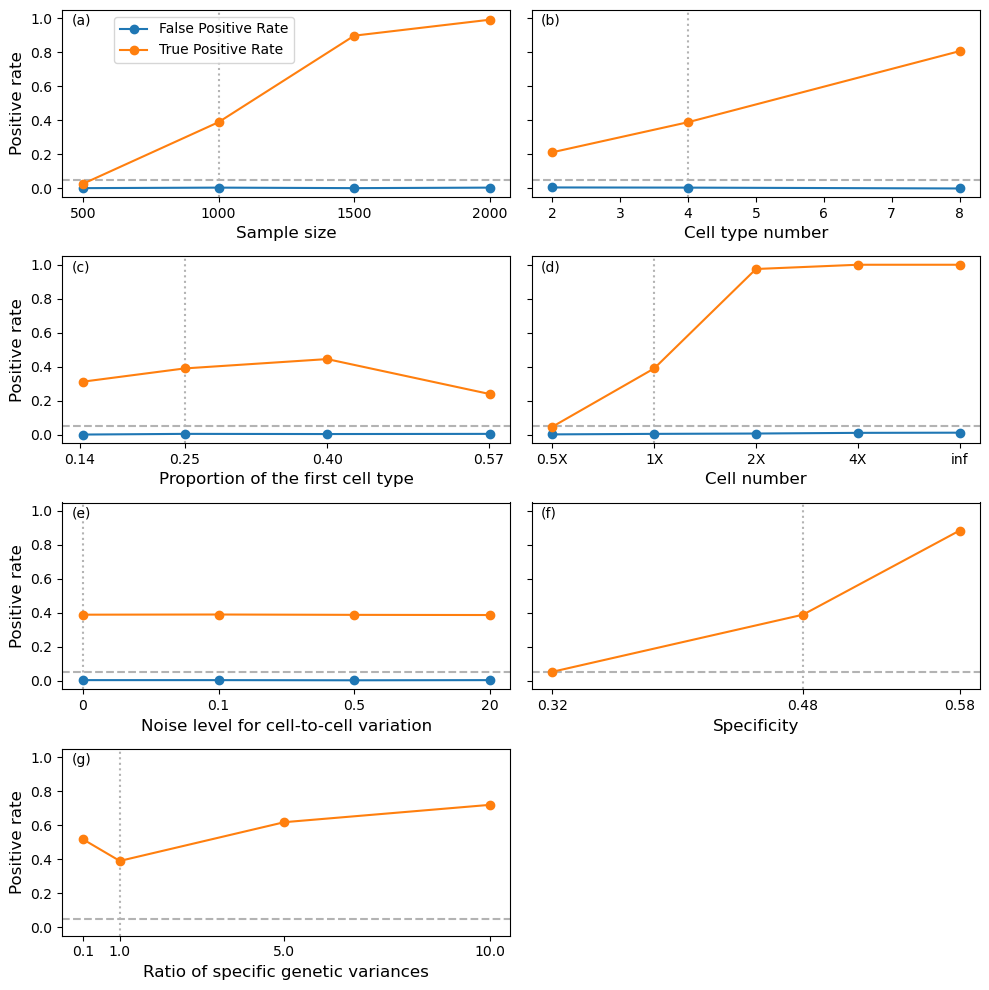

In [15]:
# fig: power
colors = sns.color_palette()
fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharey=True)

# sample size
ax = axes[0, 0]
ax.plot(ss_power['Sample size'], ss_power['False Positive rate'], marker='o', label='False Positive Rate')
ax.plot(ss_power['Sample size'], ss_power['True Positive rate'], marker='o', label='True Positive Rate')
ax.axhline(0.05, ls='--', c='.7', zorder=0)
ax.axvline(1000, ls=':', c='.7', zorder=0)
ax.set_xticks([500, 1000, 1500, 2000])
ax.set_xlabel('Sample size', fontsize=12)
ax.set_ylabel('Positive rate', fontsize=12)
ax.legend(fontsize=10, loc='upper left', bbox_to_anchor=(.1, 1))
ax.text(0.02, 0.92, "(a)", transform=ax.transAxes)



# cell type number
ax = axes[0, 1]
ax.plot(ctn_power['Cell type number'], ctn_power['False Positive rate'], marker='o', label='False Positive Rate')
ax.plot(ctn_power['Cell type number'], ctn_power['True Positive rate'], marker='o', label='True Positive Rate')
ax.axhline(0.05, ls='--', c='.7', zorder=0)
ax.axvline(4, ls=':', c='.7', zorder=0)
ax.set_xlabel("Cell type number", fontsize=12)
ax.text(0.02, 0.92, "(b)", transform=ax.transAxes)



# cell type proportion
ax = axes[1, 0]
ax.plot(ctp_power['First cell type proportion'], ctp_power['False Positive rate'], marker='o', label='False Positive Rate')
ax.plot(ctp_power['First cell type proportion'], ctp_power['True Positive rate'], marker='o', label='True Positive Rate')
ax.set_xticks(np.round(ctp_power['First cell type proportion'], 2))
ax.axhline(0.05, ls='--', c='.7', zorder=0)
ax.axvline(.25, ls=':', c='.7', zorder=0)
ax.set_xlabel('Proportion of the first cell type', fontsize=12)
ax.set_ylabel('Positive rate', fontsize=12)
ax.text(0.02, 0.92, "(c)", transform=ax.transAxes)

# cell number
ax = axes[1, 1]
ax.plot(nu_power['Cell number'], nu_power['False Positive rate'], marker='o', label='False Positive Rate')
ax.plot(nu_power['Cell number'], nu_power['True Positive rate'], marker='o', label='True Positive Rate')
ax.axhline(0.05, ls='--', c='.7', zorder=0)
ax.axvline(1, ls=':', c='.7', zorder=0)
ax.set_xlabel("Cell number", fontsize=12)
ax.text(0.02, 0.92, "(d)", transform=ax.transAxes)


# nu noise
ax = axes[2, 0]
ax.plot(noisy_nu_power['Noise'], noisy_nu_power['False Positive rate'], marker='o', label='False Positive Rate')
ax.plot(noisy_nu_power['Noise'], noisy_nu_power['True Positive rate'], marker='o', label='True Positive Rate')
ax.axhline(0.05, ls='--', c='.7', zorder=0)
ax.axvline(0, ls=':', c='.7', zorder=0)
ax.set_xlabel("Noise level for cell-to-cell variation", fontsize=12)
ax.set_ylabel('Positive rate', fontsize=12)
ax.text(0.02, 0.92, "(e)", transform=ax.transAxes)


# specificity
ax = axes[2, 1]
ax.plot(np.round(spec_power['Specificity'], 2), spec_power['True Positive rate'], marker='o', label='True Positive Rate', color=colors[1])
ax.set_xticks(np.round(spec_power['Specificity'], 2))
ax.axhline(0.05, ls='--', c='.7', zorder=0)
ax.axvline(spec_power['Specificity'].iloc[1], ls=':', c='.7', zorder=0)
ax.set_xlabel('Specificity', fontsize=12)
ax.text(0.02, 0.92, "(f)", transform=ax.transAxes)

# V
ax = axes[3, 0]
ax.plot(V_power['V1'], V_power['True Positive rate'], marker='o', label='True Positive Rate', color=colors[1])
ax.axhline(0.05, ls='--', c='.7', zorder=0)
ax.axvline(1, ls=':', c='.7', zorder=0)
ax.set_xticks(np.round(V_power['V1'], 1))
ax.set_xlabel("Ratio of specific genetic variances", fontsize=12)
ax.set_ylabel('Positive rate', fontsize=12)
ax.text(0.02, 0.92, "(g)", transform=ax.transAxes)

axes[3, 1].set_visible(False)

fig.tight_layout()

# Nongaussian simulation

[2026-02-06 12:56:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:56:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:56:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:56:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:56:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

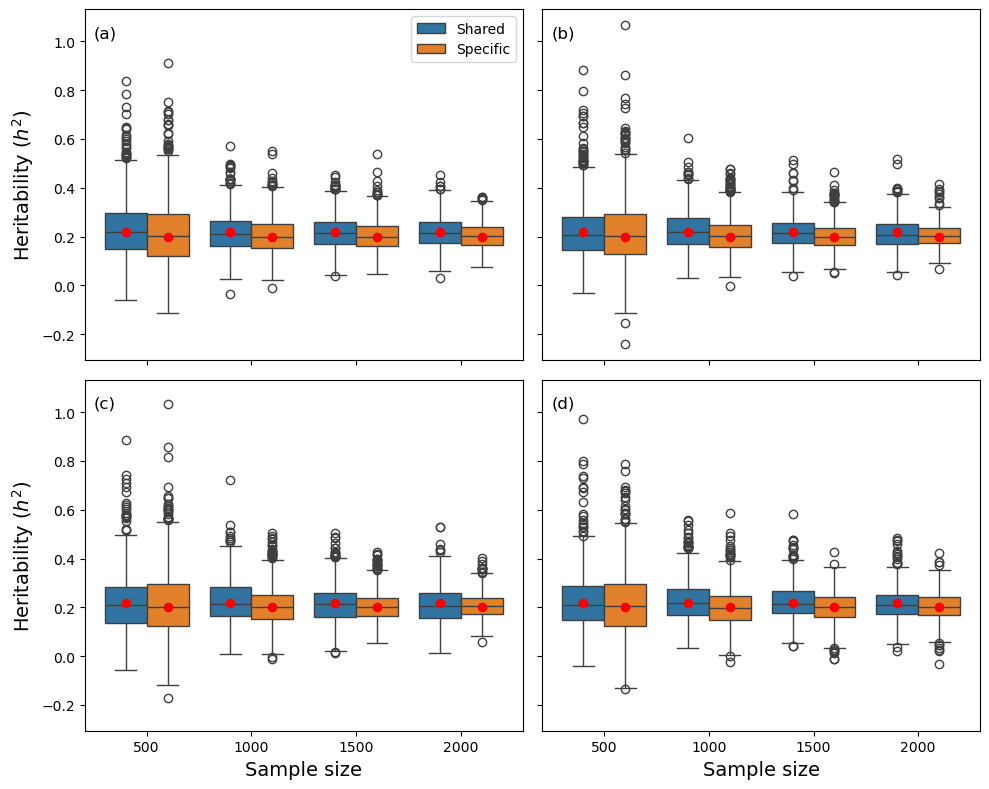

In [16]:
dist_g=['gaussian', 'spikeslab', 'spikeslab', 't2']
dist_v=['spikeslab', 'gaussian', 'spikeslab', 't2']

fs = 12
# amin, amax = -1.5, 2

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for g, v, ax, label in zip(dist_g, dist_v, axes.flatten(), ['(a)', '(b)', '(c)', '(d)']):
    out = np.load(f'../../analysis/sim/free/L_20_nL_80/{g}_g.{v}_e/AGGss.he.npy', allow_pickle=True).item()
    data = []
    for sample_size in out.keys():
        df = util.read_out(out, [f'{sample_size}:free:shared_h2', f'{sample_size}:free:specific_h2'])
        df = df.rename(columns={f'{sample_size}:free:shared_h2': 'Shared', f'{sample_size}:free:specific_h2': 'Specific'})
        df = df.melt(var_name='Category', value_name='h2')
        df['Sample size'] = int(sample_size)
        data.append(df)
    df = pd.concat(data)
    df['Sample size'] = df['Sample size'].astype('category')
    # df['h2'] = df['h2'].clip(amin, amax)  # clip
    sns.boxplot(data=df, x='Sample size', y='h2', hue='Category', ax=ax)

    if ax == axes[0, 0]:
        ax.legend()
    else:
        ax.get_legend().remove()

    # simulated h2
    xs = plot.snsbox_get_x(ss_data['Sample size'].nunique(), 2)
    ax.scatter(xs, ss_h2, color='r', zorder=10)

    ax.text(0.02, 0.92, label, transform=ax.transAxes, fontsize=fs)
    # ax.set_ylim((ymin, ymax))
axes[1, 0].set_xlabel('Sample size', fontsize=fs+2)
axes[1, 1].set_xlabel('Sample size', fontsize=fs+2)
axes[0, 0].set_ylabel(r'Heritability ($h^2$)', fontsize=fs+2)
axes[1, 0].set_ylabel(r'Heritability ($h^2$)', fontsize=fs+2)

fig.tight_layout()

# Varying number of causal variants

In [17]:
# Varying number of causal variants
L100_out = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_100_nL_0/out.he.noJK.npy', allow_pickle=True).item()
L10_out = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_10_nL_90/out.he.noJK.npy', allow_pickle=True).item()

[2026-02-06 12:56:55 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:56:55 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


  Category        h2 Number of causal variants
0   Shared  0.043057                        20
1   Shared  0.256730                        20
2   Shared  0.229832                        20
3   Shared  0.231576                        20
4   Shared  0.166622                        20
Number of causal variants  Category
10                         Shared      0.007858
                           Specific    0.006491
100                        Shared      0.004948
                           Specific    0.004936
20                         Shared      0.005880
                           Specific    0.005366
Name: h2, dtype: float64


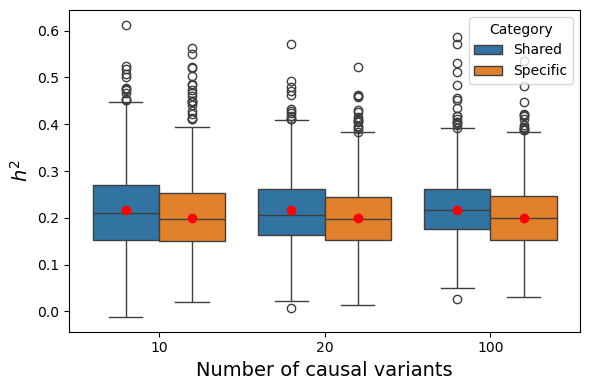

In [18]:
hom_g2 = 0.13
hom_e2 = 0.11
ss_Vs = np.load('../../analysis/sim/free/AGGss.true_V.npy', allow_pickle=True).item()
ss_Ws = np.load('../../analysis/sim/free/AGGss.true_W.npy', allow_pickle=True).item()

key = '1000'
V, W = ss_Vs[key], ss_Ws[key]
V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
real_shared_h2 = hom_g2 / (hom_g2 + V_bar + hom_e2 + W_bar)
real_specific_h2 = V_bar / (hom_g2 + V_bar + hom_e2 + W_bar)
real_h2 = np.array([real_shared_h2, real_specific_h2] * 3)

# plot
fs = 12
# amin, amax = -1.5, 2

fig, ax = plt.subplots(figsize=(6, 4))

ss_data_1000 = ss_data[ss_data['Sample size'] == 1000]
ss_data_1000.drop(columns=['Sample size'], inplace=True)
ss_data_1000['Number of causal variants'] = '20'

data = [ss_data_1000]
for out, label in zip([L100_out, L10_out], ['100', '10']):
    df = util.read_out(out, ['free:shared_h2', 'free:specific_h2'])
    df = df.rename(columns={'free:shared_h2': 'Shared', 'free:specific_h2': 'Specific'})
    df = df.melt(var_name='Category', value_name='h2')
    df['Number of causal variants'] = label
    data.append(df)
df = pd.concat(data)
print(df.head())

print(df.groupby(['Number of causal variants', 'Category'])['h2'].var())
df['Number of causal variants'] = df['Number of causal variants'].astype('category')
# df['h2'] = df['h2'].clip(amin, amax)  # clip
sns.boxplot(
    data=df,
    x='Number of causal variants',
    y='h2',
    hue='Category',
    ax=ax,
    order=['10', '20', '100']  # set desired order here
)

# simulated h2
xs = plot.snsbox_get_x(df['Number of causal variants'].nunique(), 2)
ax.scatter(xs, real_h2, color='r', zorder=10)

# ax.set_ylim((ymin, ymax))
ax.set_xlabel('Number of causal variants', fontsize=fs+2)
ax.set_ylabel(r'$h^2$', fontsize=fs+2)

fig.tight_layout()

# Permutation

## QQ plot

Max observed p: 10.862849920276098, 5.28363384077034
Contingency table:
 [[9, 184], [np.int64(36), np.int64(10059)]]
Odds ratio: 13.66711956521739
Enrichment p-value: 1.1810923287237703e-07
0.17534948107996615 7.867711830821198e-72
0.019841030558695114 0.04417516714832267


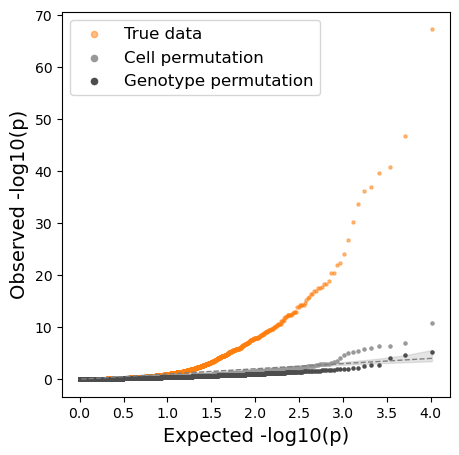

In [19]:
sorted_ct_df = ct_df.sort_values(by='p_V')
geno_p = geno_df['p_V'].sort_values().to_numpy()
real_data_p = -np.log10(np.sort(jk['p']['free']['V']))
assert sorted_ct_df.shape[0] == len(geno_p)
assert sorted_ct_df.shape[0] == len(real_data_p)

# expected vs observed
n = len(geno_p)
expected = -np.log10((np.arange(1, n + 1)) / (n + 1))
sorted_ct_df['expected'] = expected
observed_ct = -np.log10(sorted_ct_df['p_V'].to_numpy())
observed_geno = -np.log10(geno_p)
print(f'Max observed p: {np.max(observed_ct)}, {np.max(observed_geno)}')

fig, ax = plt.subplots(figsize=(5, 5))
fs = 12
colors = sns.color_palette()

# Plot the diagonal
ax.plot(expected, expected, color='grey', linestyle='--', lw=1)

# Add 95% confidence interval
ci = 0.95
lower = -np.log10(stats.beta.ppf(0.025, np.arange(1, n+1), np.arange(n, 0, -1)))
upper = -np.log10(stats.beta.ppf(0.975, np.arange(1, n+1), np.arange(n, 0, -1)))
ax.fill_between(expected, lower, upper, color='grey', alpha=0.2)

ax.scatter(expected, real_data_p, color=sns.color_palette()[1], alpha=.5, s=5, label='True data')
# ax.scatter(expected, observed_ct, color=colors[0], s=5, label='Cell permutation')
ax.scatter(expected, observed_ct, color='0.6', s=5, label='Cell permutation')
# significant points
sig_ct_df = sorted_ct_df.loc[(sorted_ct_df['p:free:V'] < 0.05/len(jk['gene']))]

# Fisher’s Exact Test (alternative='greater' tests for enrichment)
N_total = n
N_real_sig = sig_ct_df.shape[0]
N_perm_sig = (ct_df['p_V'] < 0.01).sum()  # total genes with permutation p < 0.01
N_overlap = sig_ct_df.loc[sig_ct_df['p_V'] < 0.01].shape[0]

table = [
    [N_overlap, N_real_sig - N_overlap],
    [N_perm_sig - N_overlap, N_total - N_real_sig - N_perm_sig + N_overlap]
]

oddsratio, p_value = stats.fisher_exact(table)

print("Contingency table:\n", table)
print("Odds ratio:", oddsratio)
print("Enrichment p-value:", p_value)

# spearman correlation
corr, pval = stats.spearmanr(ct_df['p_V'], ct_df['p:free:V'])
print(corr, pval)
tmp_geno_df = geno_df.merge(jk_df)
corr, pval = stats.spearmanr(tmp_geno_df['p_V'], tmp_geno_df['p:free:V'])
print(corr, pval)


ax.scatter(expected, observed_geno, color='0.3', s=5, label='Genotype permutation')
ax.set_xlabel('Expected -log10(p)', fontsize=fs+2)
ax.set_ylabel('Observed -log10(p)', fontsize=fs+2)
ax.legend(fontsize=fs, markerscale=2)

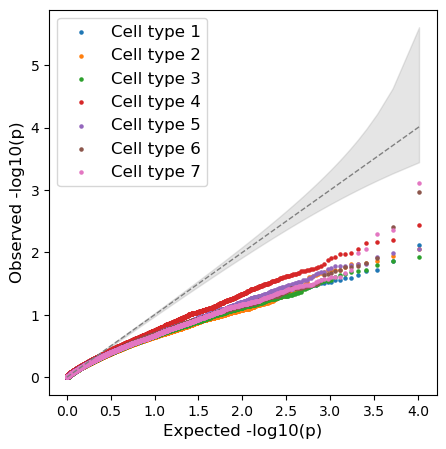

In [20]:
# Q-Q plot for permutation simulation per cell type
tmp_ct_df = util.read_out(ct_out, ['p:free:vc'])

# expected
n = tmp_ct_df.shape[0]
expected = -np.log10((np.arange(1, n + 1)) / (n + 1))

fig, ax = plt.subplots(figsize=(5, 5))
fs = 12
colors = sns.color_palette()

# Plot the diagonal
ax.plot(expected, expected, color='grey', linestyle='--', lw=1)

# Add 95% confidence interval
ci = 0.95
lower = -np.log10(stats.beta.ppf(0.025, np.arange(1, n+1), np.arange(n, 0, -1)))
upper = -np.log10(stats.beta.ppf(0.975, np.arange(1, n+1), np.arange(n, 0, -1)))
ax.fill_between(expected, lower, upper, color='grey', alpha=0.2)

for i in range(7):
    observed_ct = -np.log10(np.sort(tmp_ct_df[f'p:free:vc_{i}'].to_numpy()))
    ax.scatter(expected, observed_ct, s=5, label=f'Cell type {i+1}')

ax.set_xlabel('Expected -log10(p)', fontsize=fs)
ax.set_ylabel('Observed -log10(p)', fontsize=fs)
ax.legend(fontsize=fs)

## Stratefy by expression level and Permute cell type subset and Downsampling reads and cells

In [21]:
permuted_all_out = np.load('../../analysis/sim/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/permute_ct/he.npy', allow_pickle=True).item()
permuted_2ct_out = np.load('../../analysis/sim/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/permute_ct/CD4ET_CD4NC/he.npy', allow_pickle=True).item()
permuted_2ct_b_out = np.load('../../analysis/sim/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/permute_ct/CD4NC_BIN/he.npy', allow_pickle=True).item()
permuted_4ct_out = np.load('../../analysis/sim/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/permute_ct/CD4ET_CD4NC_CD8ET_CD8NC/he.npy', allow_pickle=True).item()
permuted_4ct_b_out = np.load('../../analysis/sim/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/permute_ct/CD4ET_CD4NC_BIN_BMem/he.npy', allow_pickle=True).item()

permuted_all_df = util.read_out(permuted_all_out, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
permuted_all_df['t'] = permuted_all_df['free:hom_g2'] + permuted_all_df['free:v'] + permuted_all_df['free:hom_e2'] + permuted_all_df['free:w']
permuted_all_df = permuted_all_df.loc[permuted_all_df['t'] > 0, ['free:shared_h2', 'free:specific_h2']]
permuted_all_df = permuted_all_df.melt(var_name='Category', value_name='h2').assign(Cells='All')

permuted_2ct_df = util.read_out(permuted_2ct_out, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
permuted_2ct_df['t'] = permuted_2ct_df['free:hom_g2'] + permuted_2ct_df['free:v'] + permuted_2ct_df['free:hom_e2'] + permuted_2ct_df['free:w']
permuted_2ct_df = permuted_2ct_df.loc[permuted_2ct_df['t'] > 0, ['free:shared_h2', 'free:specific_h2']]
permuted_2ct_df = permuted_2ct_df.melt(var_name='Category', value_name='h2').assign(Cells='2')
permuted_2ct_df['Cell types'] = 'CD4 NC, CD4 ET'
d = .2
permuted_2ct_df['x'] = 0

permuted_2ct_b_df = util.read_out(permuted_2ct_b_out, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
permuted_2ct_b_df['t'] = permuted_2ct_b_df['free:hom_g2'] + permuted_2ct_b_df['free:v'] + permuted_2ct_b_df['free:hom_e2'] + permuted_2ct_b_df['free:w']
permuted_2ct_b_df = permuted_2ct_b_df.loc[permuted_2ct_b_df['t'] > 0, ['free:shared_h2', 'free:specific_h2']]
permuted_2ct_b_df = permuted_2ct_b_df.melt(var_name='Category', value_name='h2').assign(Cells='2')
permuted_2ct_b_df['Cell types'] = 'CD4 NC, B IN'
permuted_2ct_b_df['x'] = d

permuted_4ct_df = util.read_out(permuted_4ct_out, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
permuted_4ct_df['t'] = permuted_4ct_df['free:hom_g2'] + permuted_4ct_df['free:v'] + permuted_4ct_df['free:hom_e2'] + permuted_4ct_df['free:w']
permuted_4ct_df = permuted_4ct_df.loc[permuted_4ct_df['t'] > 0, ['free:shared_h2', 'free:specific_h2']]
permuted_4ct_df = permuted_4ct_df.melt(var_name='Category', value_name='h2').assign(Cells='4')
permuted_4ct_df['Cell types'] = 'CD4 NC, CD4 ET, CD8 NC, CD8 ET'
permuted_4ct_df['x'] = 1

permuted_4ct_b_df = util.read_out(permuted_4ct_b_out, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
permuted_4ct_b_df['t'] = permuted_4ct_b_df['free:hom_g2'] + permuted_4ct_b_df['free:v'] + permuted_4ct_b_df['free:hom_e2'] + permuted_4ct_b_df['free:w']
permuted_4ct_b_df = permuted_4ct_b_df.loc[permuted_4ct_b_df['t'] > 0, ['free:shared_h2', 'free:specific_h2']]
permuted_4ct_b_df = permuted_4ct_b_df.melt(var_name='Category', value_name='h2').assign(Cells='4')
permuted_4ct_b_df['Cell types'] = 'CD4 NC, CD4 ET, B IN, B Mem'
permuted_4ct_b_df['x'] = 1 + d

permuted_0ct_df = util.read_out(jk, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
permuted_0ct_df['t'] = permuted_0ct_df['free:hom_g2'] + permuted_0ct_df['free:v'] + permuted_0ct_df['free:hom_e2'] + permuted_0ct_df['free:w']
permuted_0ct_df = permuted_0ct_df.loc[permuted_0ct_df['t'] > 0, ['free:shared_h2', 'free:specific_h2']]
permuted_0ct_df = permuted_0ct_df.melt(var_name='Category', value_name='h2').assign(Cells='0')

df = pd.concat([permuted_all_df, permuted_2ct_df, permuted_4ct_df, permuted_0ct_df], ignore_index=True)
df_b = pd.concat([permuted_all_df, permuted_2ct_b_df, permuted_4ct_b_df, permuted_0ct_df], ignore_index=True)
df2 = pd.concat([permuted_2ct_df, permuted_2ct_b_df, permuted_4ct_df, permuted_4ct_b_df], ignore_index=True)
df['Cells'] = df['Cells'].astype('category')

In [22]:
# unbiased after stratification of bins
# filter out extreme h2 estimates
ct_df_tmp = ct_df.loc[(ct_df['bio_var'] > 0)].copy()
geno_df_tmp = geno_df.loc[(geno_df['bio_var'] > 0)].copy()

# divide into bins
ct_df_tmp['mean_expr_bin'] = pd.qcut(ct_df_tmp['mean_expr'], q=3, labels=['Low', 'Medium', 'High'])
geno_df_tmp['mean_expr_bin'] = pd.qcut(geno_df_tmp['mean_expr'], q=3, labels=['Low', 'Medium', 'High'])
ct_df_tmp['var_expr_bin'] = pd.qcut(ct_df_tmp['var_expr'], q=3, labels=['Low', 'Medium', 'High'])
geno_df_tmp['var_expr_bin'] = pd.qcut(geno_df_tmp['var_expr'], q=3, labels=['Low', 'Medium', 'High'])

In [23]:
# downsampling cells and reads
cell_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/cellsampling.he.npy'
read_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/readsampling.he.npy'

cell_out = np.load(cell_f, allow_pickle=True).item()
# only keep <= 200 cells
cell_out = {k: v for k, v in cell_out.items() if k <= 200}
read_out = np.load(read_f, allow_pickle=True).item()
# only keep .75, .5, .25 read proportions
read_out = {k: v for k, v in read_out.items() if k in [0.75, 0.5, 0.25]}
print(read_out.keys())

primary_df = util.read_out(jk, ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
primary_df['t'] = primary_df['free:hom_g2'] + primary_df['free:v'] + primary_df['free:hom_e2'] + primary_df['free:w']
primary_df = primary_df.loc[primary_df['t'] > 0]
print(primary_df.shape[0])

cell_data = {}
merged_cell_df = primary_df.copy()
merged_cell_df['Cell number'] = 'All'
for key in cell_out.keys():
    # print(key)
    tmp_cell_df = util.read_out(cell_out[key], ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
    tmp_cell_df['t'] = tmp_cell_df['free:hom_g2'] + tmp_cell_df['free:v'] + tmp_cell_df['free:hom_e2'] + tmp_cell_df['free:w']
    tmp_cell_df = tmp_cell_df.loc[tmp_cell_df['t'] > 0]
    # print(tmp_cell_df.shape[0])
    tmp = primary_df.merge(tmp_cell_df, on='gene', suffixes=('', f'_{key}'))
    cell_data[key] = tmp
    # print(tmp.shape[0])
    tmp_cell_df['Cell number'] = str(key)
    merged_cell_df = pd.concat([merged_cell_df, tmp_cell_df], axis=0)
# keep overlapping genes
merged_cell_df = merged_cell_df.loc[merged_cell_df['gene'].isin(primary_df['gene'])]
for key in cell_out.keys():
    merged_cell_df = merged_cell_df.loc[merged_cell_df['gene'].isin(cell_data[key]['gene'])]
print(merged_cell_df['gene'].nunique())
print(merged_cell_df['Cell number'].unique())
merged_cell_df = merged_cell_df.rename(columns={'free:hom_g2': 'Hom_g2', 'free:v': 'V', 'free:shared_h2': 'Shared', 'free:specific_h2': 'Specific'})
merged_cell_df = merged_cell_df.melt(id_vars=['gene', 'Cell number'], value_vars=['Shared', 'Specific'], var_name='Component', value_name='Heritability (h2)')


read_data = {}
merged_read_df = primary_df.copy()
merged_read_df['Read proportion'] = 'All'
for key in read_out.keys():
    tmp_read_df = util.read_out(read_out[key], ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
    tmp_read_df['t'] = tmp_read_df['free:hom_g2'] + tmp_read_df['free:v'] + tmp_read_df['free:hom_e2'] + tmp_read_df['free:w']
    tmp_read_df = tmp_read_df.loc[tmp_read_df['t'] > 0]
    # print(tmp_read_df.shape[0])
    tmp = primary_df.merge(tmp_read_df, on='gene', suffixes=('', f'_{key}'))
    read_data[key] = tmp
    # print(tmp.shape[0])
    tmp_read_df['Read proportion'] = str(key)
    merged_read_df = pd.concat([merged_read_df, tmp_read_df], axis=0)
# keep overlapping genes
merged_read_df = merged_read_df.loc[merged_read_df['gene'].isin(primary_df['gene'])]
for key in read_out.keys():
    merged_read_df = merged_read_df.loc[merged_read_df['gene'].isin(read_data[key]['gene'])]
print(merged_read_df['gene'].nunique())
merged_read_df = merged_read_df.rename(columns={'free:hom_g2': 'Hom_g2', 'free:v': 'V', 'free:shared_h2': 'Shared', 'free:specific_h2': 'Specific'})
merged_read_df = merged_read_df.melt(id_vars=['gene', 'Read proportion'], value_vars=['Shared', 'Specific'], var_name='Component', value_name='Heritability (h2)')

dict_keys([0.25, 0.5, 0.75])
9067
3994
<StringArray>
['All', '11', '20', '50', '100', '200']
Length: 6, dtype: str
4616


/tmp/ipykernel_134534/1879523159.py:34: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  axes['A'].legend(handles=handles, labels=['Shared', 'Specific'], fontsize=fs - 2, loc='upper left')


Cells  Category        
0      free:shared_h2      0.022683
       free:specific_h2    0.010240
2      free:shared_h2      0.022775
       free:specific_h2    0.010338
4      free:shared_h2      0.023841
       free:specific_h2    0.008112
All    free:shared_h2      0.035523
       free:specific_h2   -0.002152
Name: h2, dtype: float64


/tmp/ipykernel_134534/1879523159.py:48: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  leg = ax.legend(handles=handles, labels=['Shared', 'Specific'], fontsize=fs-2, loc='lower left')


Component      Shared  Specific
Cell number                    
100          0.022893  0.009475
11           0.018320  0.010526
20           0.023747  0.008442
200          0.022438  0.010401
50           0.023258  0.010461
All          0.022140  0.010205


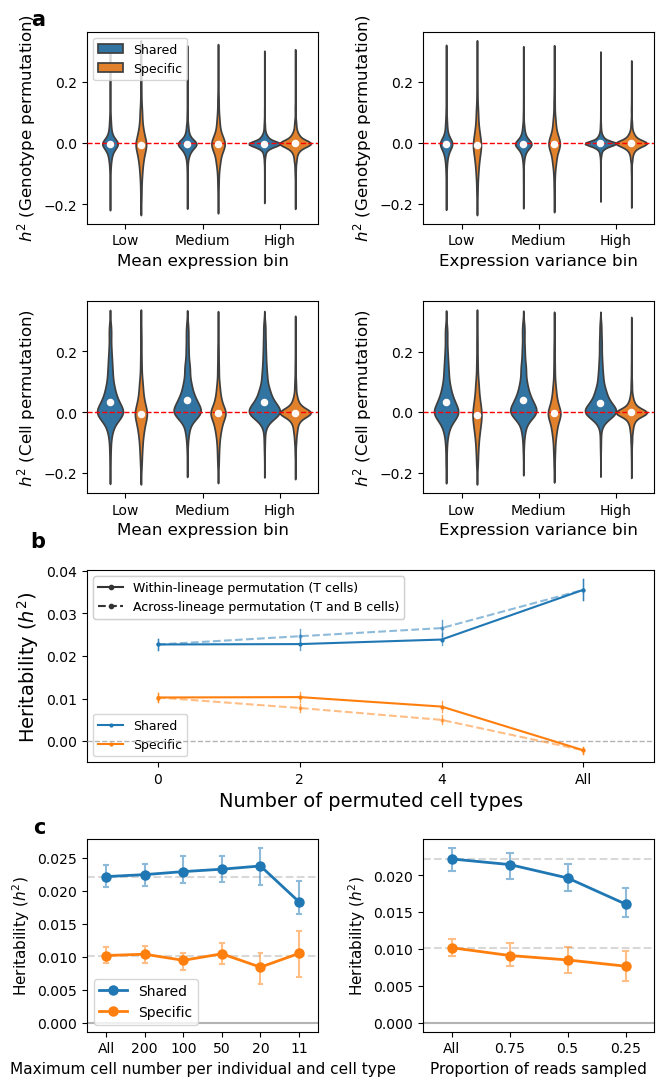

In [24]:
fs = 11

layout = """
AB
CD
EE
FG
"""

fig, axes = plt.subplot_mosaic(layout, figsize=(7, 11))

left_axes = ['A', 'B', 'C', 'D']
ylabels = ['Genotype permutation', 'Cell permutation']
for i, tmp_df in enumerate([geno_df_tmp, ct_df_tmp]):
    data2 = tmp_df.melt(id_vars=['mean_expr_bin', 'var_expr_bin'], value_vars=['specific_h2', 'shared_h2'], var_name='Type', value_name='var')
    raw_data2 = data2.copy()
    data2.loc[(data2['var'] < -.2) | (data2['var'] > .3), 'var'] = np.nan  # remove extreme values for better visualization
    for j, bin_type in enumerate(['mean_expr_bin', 'var_expr_bin']):
        ax = axes[left_axes[i*2 + j]]
        sns.violinplot(data2, x=bin_type, y='var', hue='Type', ax=ax, inner=None, hue_order=['shared_h2', 'specific_h2'],)
        xs = plot.snsbox_get_x(len(data2[bin_type].unique()), 2)
        dodge = (xs[1] - xs[0])
        sns.pointplot(raw_data2, x=bin_type, y='var', hue='Type', hue_order=['shared_h2', 'specific_h2'], ax=ax, estimator=np.median,
                      markers='.', linestyles="none", palette=['snow', 'snow'], dodge=dodge,
                      err_kws={'linewidth': 1, 'alpha': 0.3}, zorder=10, seed=123)
        ax.axhline(0, color='r', linestyle='--', lw=1, zorder=9)
        ax.legend().set_visible(False)
        handles, labels = ax.get_legend_handles_labels()
        if bin_type == 'mean_expr_bin':
            ax.set_xlabel('Mean expression bin', fontsize=12)
        elif bin_type == 'var_expr_bin':
            ax.set_xlabel('Expression variance bin', fontsize=12)
        ax.set_ylabel(f'$h^2$ ({ylabels[i]})', fontsize=12)
axes['A'].legend(handles=handles, labels=['Shared', 'Specific'], fontsize=fs - 2, loc='upper left')

fig.text(.09, .995, 'a', fontsize=fs+4, fontweight='bold', va='top', ha='right')

ax = axes['E']
sns.pointplot(data=df, x='Cells', y='h2', hue='Category', ax=ax, estimator='median', linewidth=1.5,
              markers='.', linestyles="-", err_kws={'linewidth':1, 'alpha':0.7}, zorder=10, seed=123)
sns.pointplot(data=df_b, x='Cells', y='h2', hue='Category', ax=ax, estimator='median', linewidth=1.5, alpha=0.5,
              markers='.', linestyles="--", err_kws={'linewidth':1, 'alpha':0.7}, zorder=10, seed=123)

print(df.groupby(['Cells', 'Category'])['h2'].median())
ax.axhline(0, color='.7', linestyle='--', lw=1, zorder=9)

handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=['Shared', 'Specific'], fontsize=fs-2, loc='lower left')

style_handles = [lines.Line2D([0], [0], color='0.2', marker='.', linestyle='-', markersize=6),
                 lines.Line2D([0], [0], color='0.2', marker='.', linestyle='--', markersize=6)]
style_labels = ['Within-lineage permutation (T cells)', 'Across-lineage permutation (T and B cells)']
leg2 = ax.legend(style_handles, style_labels, fontsize=fs-2, loc='upper left', title=None)
ax.add_artist(leg)
ax.add_artist(leg2)

ax.set_xlabel('Number of permuted cell types', fontsize=14)
ax.set_ylabel(r'Heritability ($h^2$)', fontsize=14)
fig.text(.09, .52, 'b', fontsize=fs+4, fontweight='bold', va='top', ha='right')



# downsampling reads and cells
# cell
colors = sns.color_palette()

ax = axes['F']
tmp_df = merged_cell_df.copy()
sns.pointplot(data=tmp_df, x='Cell number', y='Heritability (h2)', hue='Component', estimator='median', capsize=.1,
    ax=ax, palette=[colors[0], colors[1]], markers='o', markersize=6, linewidth=2, err_kws=dict(linewidth=1.5, alpha=0.5),
    order=['All'] + np.sort([int(x) for x in merged_cell_df['Cell number'].unique() if x != 'All']).astype(str).tolist()[::-1])
ax.legend(title=None)
# plot median "All" lines separately for each component (avoid passing an array to axhline)
all_medians = merged_cell_df.loc[merged_cell_df['Cell number'] == 'All'].groupby('Component')['Heritability (h2)'].median()
ax.axhline(y=all_medians['Shared'], color='.7', linestyle='--', linewidth=1.5, alpha=0.5, zorder=0)
ax.axhline(y=all_medians['Specific'], color='.7', linestyle='--', linewidth=1.5, alpha=0.5, zorder=0)

ax.set_xlabel('Maximum cell number per individual and cell type', fontsize=fs)
ax.set_ylabel('Heritability ($h^2$)', fontsize=fs)
ax.axhline(y=0, color='0.7')
fig.text(.09, .26, 'c', fontsize=fs+4, fontweight='bold', va='top', ha='right')

print(merged_cell_df.groupby(['Cell number', 'Component'])['Heritability (h2)'].median().unstack())

# read
ax = axes['G']
sns.pointplot(data=merged_read_df, x='Read proportion', y='Heritability (h2)', hue='Component', ax=ax, palette=[colors[0], colors[1]],
              estimator='median', capsize=.1,
              markers='o', markersize=6, linewidth=2, err_kws=dict(linewidth=1.5, alpha=0.5),
              order=['All'] + np.sort([float(x) for x in merged_read_df['Read proportion'].unique() if x != 'All'])[::-1].astype(str).tolist())
# plot median "All" lines separately for each component (avoid passing an array to axhline)
all_medians = merged_read_df.loc[merged_read_df['Read proportion'] == 'All'].groupby('Component')['Heritability (h2)'].median()
ax.axhline(y=all_medians['Shared'], color='.7', linestyle='--', linewidth=1.5, alpha=0.5, zorder=0)
ax.axhline(y=all_medians['Specific'], color='.7', linestyle='--', linewidth=1.5, alpha=0.5, zorder=0)

ax.set_xlabel('Proportion of reads sampled', fontsize=fs)
ax.set_ylabel('Heritability ($h^2$)', fontsize=fs)
ax.legend().set_visible(False)
ax.axhline(y=0, color='0.7')


fig.tight_layout(pad=2.0)

/tmp/ipykernel_134534/3737410006.py:8: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=tmp_df.loc[tmp_df['Cells'] == '2'], x='x', y='h2', hue='Category', palette=['.7'], ax=ax, marker='o', estimator='median', err_style='bars', linestyle=':', legend=False)
/tmp/ipykernel_134534/3737410006.py:10: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=tmp_df.loc[tmp_df['Cells'] == '4'], x='x', y='h2', hue='Category', palette=['.7'], ax=ax, marker='o', estimator='median', err_style='bars', linestyle=':', legend=False)
/tmp/ipykernel_134534/3737410006.py:16: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  ax.legend(handles=handles, labels=['Shared', 'Specific'], fontsize=fs-2, loc='lower left')


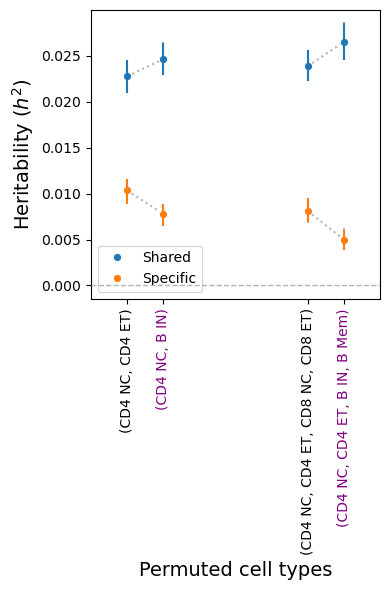

In [25]:
from matplotlib.font_manager import FontProperties

tmp_df = df2.copy()

fs = 12
fig, ax = plt.subplots(figsize=(4, 6))

sns.lineplot(data=tmp_df.loc[tmp_df['Cells'] == '2'], x='x', y='h2', hue='Category', palette=['.7'], ax=ax, marker='o', estimator='median', err_style='bars', linestyle=':', legend=False)
sns.lineplot(data=tmp_df.loc[tmp_df['Cells'] == '2'], x='x', y='h2', hue='Category', ax=ax, marker='o', estimator='median', err_style='bars', linestyle='none')
sns.lineplot(data=tmp_df.loc[tmp_df['Cells'] == '4'], x='x', y='h2', hue='Category', palette=['.7'], ax=ax, marker='o', estimator='median', err_style='bars', linestyle=':', legend=False)
sns.lineplot(data=tmp_df.loc[tmp_df['Cells'] == '4'], x='x', y='h2', hue='Category', ax=ax, marker='o', estimator='median', err_style='bars', linestyle='none')

ax.axhline(0, color='.7', linestyle='--', lw=1, zorder=9)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Shared', 'Specific'], fontsize=fs-2, loc='lower left')

ax.set_xlim(-.2, 1.2+d)

ax.set_xticks([0, d, 1, 1+d])
# You can customize tick label colors and fonts using matplotlib's set_xticklabels with FontProperties and color argument.

labels = ['(CD4 NC, CD4 ET)', '(CD4 NC, B IN)', '(CD4 NC, CD4 ET, CD8 NC, CD8 ET)', '(CD4 NC, CD4 ET, B IN, B Mem)']
colors = ['black', 'purple', 'black', 'purple']
font = FontProperties(size=10)

for ticklabel, color in zip(labels, colors):
    ax.set_xticklabels(labels, rotation=90, fontproperties=font)
for label, color in zip(ax.get_xticklabels(), colors):
    label.set_color(color)

ax.set_xlabel('Permuted cell types', fontsize=14)
ax.set_ylabel(r'Heritability ($h^2$)', fontsize=14)

fig.tight_layout()

# Full

In [26]:
# load data 
full_f = '../../analysis/sim/full/L_20_nL_80/AGGV_tril.he.noJK.npy'
full_true_V_f = '../../analysis/sim/full/AGGV_tril.true_V.npy'
full_true_W_f = '../../analysis/sim/full/AGGV_tril.true_W.npy'

full = np.load(full_f, allow_pickle=True).item()
full_true_Vs = np.load(full_true_V_f, allow_pickle=True).item()
full_true_Ws = np.load(full_true_W_f, allow_pickle=True).item()

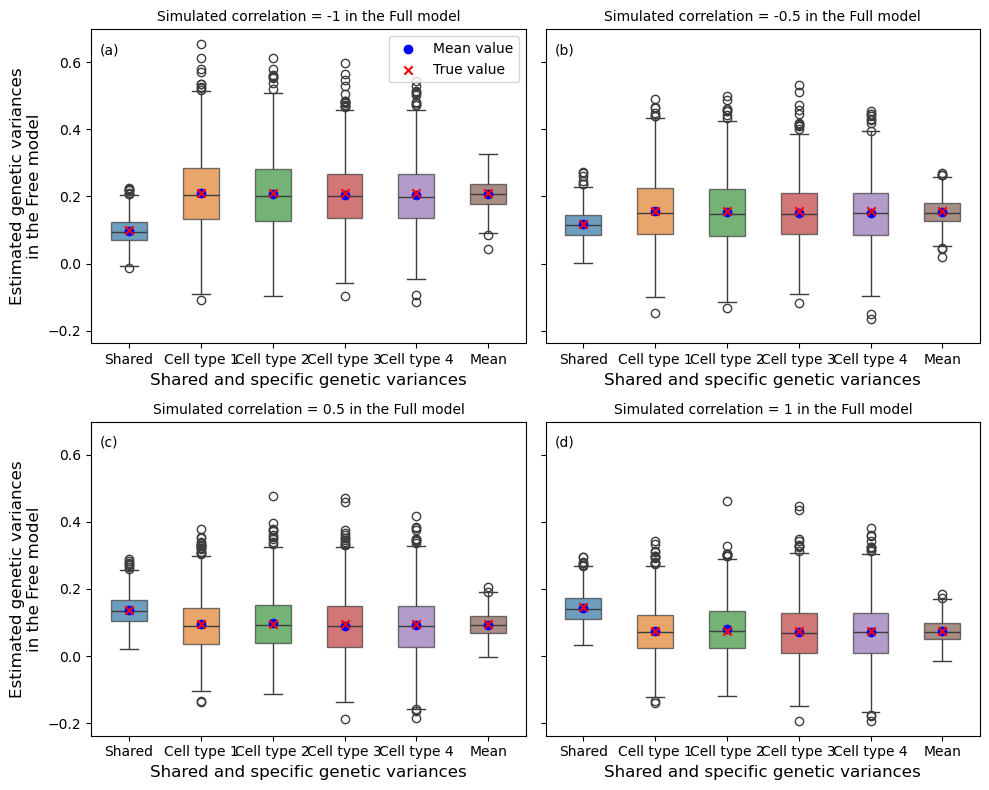

In [27]:
# when fit the Free model
free = {}
for key in full.keys():
    free[key] = util.read_out(full[key], ['free:hom_g2', 'free:V', 'free:v'])

# true Vs
true_Vs = {}
for key in full_true_Vs.keys():
    tmp_cov_avg = np.mean(full_true_Vs[key][np.tril_indices_from(full_true_Vs[key], k=-1)])
    tmp = np.diag(full_true_Vs[key]) - tmp_cov_avg
    tmp = np.append(tmp, np.mean(tmp))  # add mean
    true_Vs[key] = np.insert(tmp, 0, Hom_g2 + tmp_cov_avg)  # add Hom_g2 for shared genetic variance

# plot for each setting
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()
for i, (key, df) in enumerate(free.items()):
    sns.boxplot(data=df, ax=axes[i], width=0.5, boxprops=dict(alpha=0.7))
    # add means
    means = df.mean()
    axes[i].scatter(range(len(means)), means, color='b', zorder=10, label='Mean value')
    axes[i].set_title(f'Simulated correlation = {key.split("_")[0]} in the Full model', fontsize=10)
    axes[i].set_xlabel('Shared and specific genetic variances', fontsize=12)
    axes[i].set_ylabel(r'Estimated genetic variances''\nin the Free model', fontsize=12)
    # change x ticks to Cell type 1, Cell type 2, ...
    old_labels = [label.get_text() for label in axes[i].get_xticklabels()]
    new_labels = ['Shared'] + [f"Cell type {i + 1}" for i in range(len(old_labels) - 2)] + ['Mean']
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].set_xticklabels(new_labels)
    axes[i].tick_params(axis='both', labelsize=10)
    axes[i].text(0.02, 0.92, f"({chr(97 + i)})", transform=axes[i].transAxes)

    # add true values
    true_V = true_Vs[key]
    axes[i].scatter(range(len(true_V)), true_V, color='r', zorder=10, label='True value', marker='x')
axes[0].legend(loc='upper right')

fig.tight_layout()


[2026-02-06 12:57:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:57:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[2026-02-06 12:57:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:57:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:57:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:57:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 12:57:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

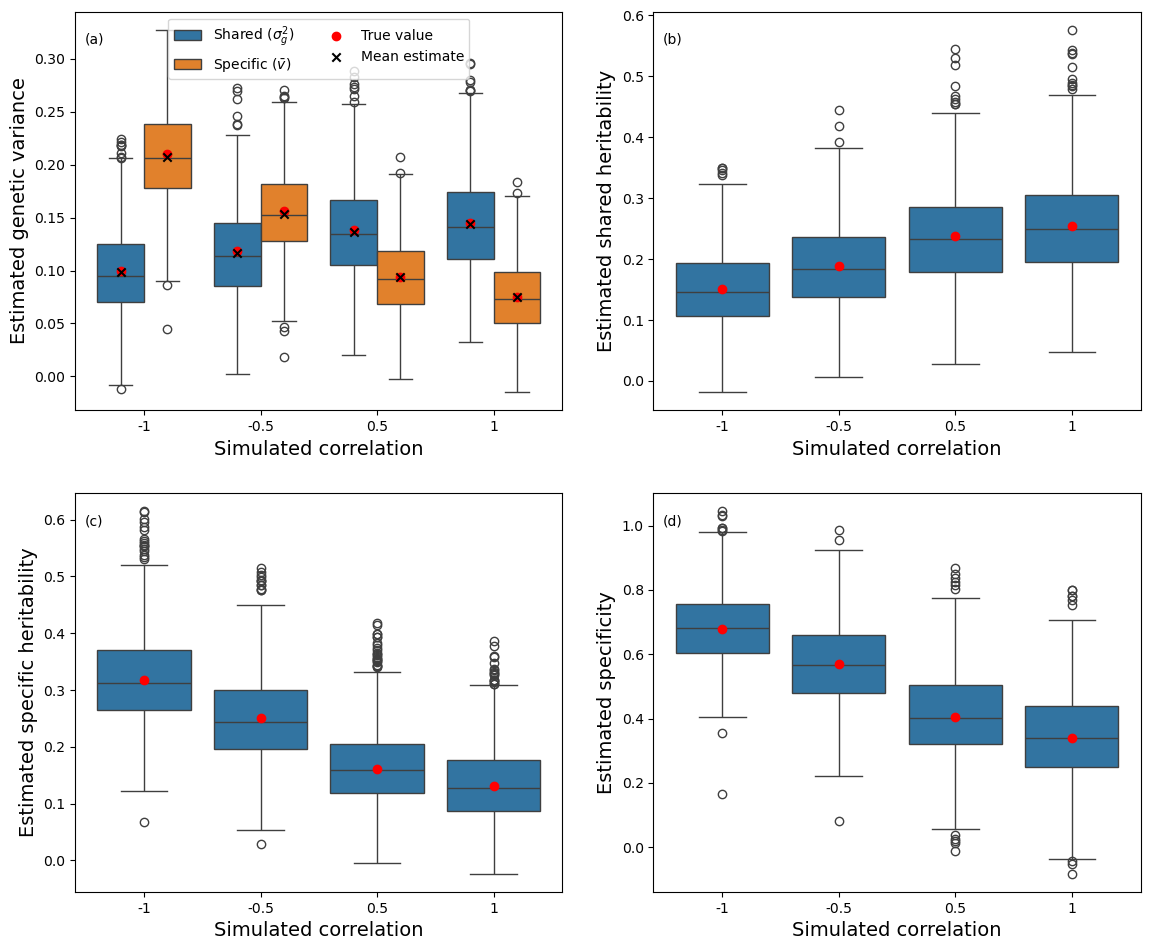

In [28]:
# shared and specific h2 and specificity
free = []
for key in full.keys():
    tmp = util.read_out(full[key], ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
    tmp['t'] = tmp['free:hom_g2'] + tmp['free:v'] + tmp['free:hom_e2'] + tmp['free:w']
    tmp['shared_h2'] = tmp['free:hom_g2'] / tmp['t']
    tmp['specific_h2'] = tmp['free:v'] / tmp['t']
    tmp['specificity'] = tmp['free:v'] / (tmp['free:hom_g2'] + tmp['free:v'])
    tmp['Setting'] = key
    free.append(tmp[['free:hom_g2', 'free:v', 'shared_h2', 'specific_h2', 'specificity', 'Setting']])
df = pd.concat(free)
df = df.rename(columns={'free:hom_g2': r'Shared ($\sigma_g^2$)', 'free:v': r'Specific ($\bar{v}$)'})
# df['shared_h2'] = df['shared_h2'].clip(None, 1)
# df['specific_h2'] = df['specific_h2'].clip(None, 1)

true_values = {}
true_hom_g2 = Hom_g2 # add shared genetic variance
true_hom_e2 = Hom_e2 # add shared environmental variance
for key in full_true_Vs.keys():
    V, W = full_true_Vs[key], full_true_Ws[key]
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    V_cov_bar = np.mean(V[np.triu_indices_from(V, k=1)])
    t = true_hom_g2 + V_bar + true_hom_e2 + W_bar
    true_shared_h2 = (true_hom_g2 + V_cov_bar) / t
    true_specific_h2 = (V_bar - V_cov_bar) / t
    true_specificity = (V_bar - V_cov_bar) / (true_hom_g2 + V_bar)
    true_values[key] = {'shared_bar': true_hom_g2 + V_cov_bar, 'specific_bar': V_bar - V_cov_bar, 
                        'shared_h2': true_shared_h2, 'specific_h2': true_specific_h2, 'specificity': true_specificity}


# boxplots for shared and specific h2 and specificity in 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

settings = list(full_true_Vs.keys())
# shared and specific variances
ax = axes[0, 0]
df_var = df.melt(id_vars=['Setting'], value_vars=[r'Shared ($\sigma_g^2$)', r'Specific ($\bar{v}$)'], 
                 var_name='Category', value_name='Variance estimate')
sns.boxplot(data=df_var, x='Setting', y='Variance estimate', hue='Category', ax=ax)
ax.set_xlabel('Simulated correlation', fontsize=14)
ax.set_ylabel('Estimated genetic variance', fontsize=14)
old_labels = [label.get_text() for label in ax.get_xticklabels()]
new_labels = [label.split('_')[0] for label in old_labels]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(new_labels)
ax.tick_params(axis='both', labelsize=10)
ax.text(0.02, 0.92, "(a)", transform=ax.transAxes)
true_shared_bars = [true_values[key]['shared_bar'] for key in settings]
true_specific_bars = [true_values[key]['specific_bar'] for key in settings]
# add true values
n_settings = len(settings)
x_shared = np.arange(n_settings) - 0.2  # left box (shared)
x_specific = np.arange(n_settings) + 0.2  # right box (specific)

ax.scatter(x_shared, true_shared_bars, color='r', zorder=10, label='True value')
ax.scatter(x_specific, true_specific_bars, color='r', zorder=10)
# add mean values
means = df_var.groupby(['Setting', 'Category'])['Variance estimate'].mean().unstack()
# Ensure means are in the same order as settings
means = means.reindex(settings)
ax.scatter(x_shared, means[r'Shared ($\sigma_g^2$)'], color='k', zorder=10, label='Mean estimate', marker='x')
ax.scatter(x_specific, means[r'Specific ($\bar{v}$)'], color='k', zorder=10, marker='x')

ax.legend(ncol=2)


# shared h2
ax = axes[0, 1]
sns.boxplot(data=df, x='Setting', y='shared_h2', ax=ax)
ax.set_xlabel('Simulated correlation', fontsize=14)
ax.set_ylabel('Estimated shared heritability', fontsize=14)
old_labels = [label.get_text() for label in ax.get_xticklabels()]
new_labels = [label.split('_')[0] for label in old_labels]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(new_labels)
ax.tick_params(axis='both', labelsize=10)
ax.text(0.02, 0.92, "(b)", transform=ax.transAxes)
true_shared_h2s = [true_values[key]['shared_h2'] for key in settings]
ax.scatter(range(len(settings)), np.clip(true_shared_h2s, None, 1), color='r', zorder=10)

# specific h2
ax = axes[1, 0]
sns.boxplot(data=df, x='Setting', y='specific_h2', ax=ax)
ax.set_xlabel('Simulated correlation', fontsize=14)
ax.set_ylabel('Estimated specific heritability', fontsize=14)
old_labels = [label.get_text() for label in ax.get_xticklabels()]
new_labels = [label.split('_')[0] for label in old_labels]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(new_labels)
ax.tick_params(axis='both', labelsize=10)
ax.text(0.02, 0.92, "(c)", transform=ax.transAxes)
true_specific_h2s = [true_values[key]['specific_h2'] for key in settings]
ax.scatter(range(len(settings)), true_specific_h2s, color='r', zorder=10)

# specificity
ax = axes[1, 1]
sns.boxplot(data=df, x='Setting', y='specificity', ax=ax)
ax.set_xlabel('Simulated correlation', fontsize=14)
ax.set_ylabel('Estimated specificity', fontsize=14)
old_labels = [label.get_text() for label in ax.get_xticklabels()]
new_labels = [label.split('_')[0] for label in old_labels]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(new_labels)
ax.tick_params(axis='both', labelsize=10)
ax.text(0.02, 0.92, "(d)", transform=ax.transAxes)
true_specificities = [true_values[key]['specificity'] for key in settings]
ax.scatter(range(len(settings)), true_specificities, color='r', zorder=10)

fig.tight_layout(pad=2.5)


In [29]:
# vars = {}
# covs = {}
# # cors = {}
# true_v11s = []
# true_v12s = []
# for key in full.keys():
#     tmp_cov = []
#     tmp_cor = []
#     tmp_var = []
#     for V in full[key]['full']['V']:
#         # tmp_cor.append(V[0, 1] / np.sqrt(V[0, 0] * V[1, 1]))
#         tmp_cov.append(V[0, 1])
#         tmp_var.append(V[0, 0])
#     vars[key] = tmp_var
#     covs[key] = tmp_cov
#     # true_v11s.append(full_true_Vs[key][0, 0])  # add 0.05 for shared genetic variance
#     true_v11s.append(full_true_Vs[key][0, 0] + Hom_g2)  # add 0.05 for shared genetic variance
#     true_v12s.append(full_true_Vs[key][0, 1] + Hom_g2)  # add 0.05 for shared genetic variance

# vars = pd.DataFrame(vars).melt(var_name='Setting', value_name='Variance estimate')
# covs = pd.DataFrame(covs).melt(var_name='Setting', value_name='Covariance estimate')
# print('Simulated correlation of total genetic effects:', np.array(true_v12s) / np.array(true_v11s))

# # plot correlation and variance estimates in one figure
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # correlation estimates
# sns.boxplot(data=covs, x='Setting', y='Covariance estimate', ax=axes[0])
# axes[0].set_xlabel('Setting (vc)', fontsize=12)
# # axes[0].set_ylabel('Covariance estimate', fontsize=12)
# axes[0].tick_params(axis='both', labelsize=10)
# axes[0].text(0.02, 0.92, "(a)", transform=axes[0].transAxes)
# settings = list(full_true_Vs.keys())
# axes[0].scatter(range(len(settings)), true_v12s, color='r', zorder=10, label='True value')
# axes[0].legend()

# # variance estimates
# sns.boxplot(data=vars, x='Setting', y='Variance estimate', ax=axes[1])
# # add mean
# means = vars.groupby('Setting')['Variance estimate'].mean()
# means = means.reindex(settings)
# print(means)
# axes[1].scatter(range(len(settings)), means, color='b', zorder=10, label='Mean value')
# axes[1].set_xlabel('Setting (vc)', fontsize=12)
# axes[1].set_ylabel('Variance estimate', fontsize=12)
# axes[1].tick_params(axis='both', labelsize=10)
# axes[1].text(0.02, 0.92, "(b)", transform=axes[1].transAxes)
# axes[1].scatter(range(len(settings)), true_v11s, color='r', zorder=10, label='True value')
# axes[1].legend()

# fig.tight_layout()

# REML

In [3]:
chol = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/out.reml.npy', allow_pickle=True).item()
nochol = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/out.reml.noCholesky.npy', allow_pickle=True).item()
# nochol = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.1_0.05_0.15_0.02_0.05_0.63_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/out.reml.noCholesky.npy', allow_pickle=True).item() # TODO: update nochol

In [4]:
print(chol['free']['opt'].keys())
print(chol['free']['opt']['time'].shape)
print(nochol['free']['opt']['time'].shape)
print(np.unique(chol['free']['opt']['success']))
print(np.unique(nochol['free']['opt']['success']))

dict_keys(['success', 'status', 'message', 'l', 'initial', 'niter', 'time'])
(1000,)
(1000,)
[ True]
[ True]


In [8]:
print(np.mean(chol['free']['opt']['time'])/60)
print(np.mean(nochol['free']['opt']['time'])/3600)

22.275246945905685
6.259628234886129


In [ ]:
print(chol['free'].keys())

dict_keys(['hom_g2', 'hom_e2', 'V', 'W', 'l', 'ct_overall_g_var', 'ct_overall_e_var', 'beta', 'fixed_vars', 'success', 'opt'])


In [ ]:
df = util.read_out(chol, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
df = df.rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'v', 'free:hom_e2': 'hom_e2', 'free:w': 'w'})
df['shared_h2'] = df['hom_g2'] / (df['hom_g2'] + df['v'] + df['hom_e2'] + df['w'])
df['specific_h2'] = df['v'] / (df['hom_g2'] + df['v'] + df['hom_e2'] + df['w'])
df['specificity'] = df['v'] / (df['hom_g2'] + df['v'])
display(df.describe())

,hom_g2,v,hom_e2,w,shared_h2,specific_h2,specificity
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.125957,0.121330,0.108011,0.242950,0.209277,0.203994,0.496383
std,0.039599,0.028530,0.034279,0.053712,0.057941,0.048764,0.110348
min,0.014193,0.044750,-0.008217,0.080127,0.027791,0.072583,0.181656
25%,0.098426,0.100372,0.085805,0.205647,0.168041,0.168046,0.413930
50%,0.123474,0.120321,0.107307,0.242262,0.205556,0.203078,0.491098
75%,0.151562,0.139797,0.129823,0.279118,0.249046,0.236567,0.570599
max,0.268927,0.230295,0.210067,0.424415,0.383227,0.367968,0.906413


## Noisy nu

In [ ]:
he_nu = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/out.he.noisy_nu.npy', allow_pickle=True).item()

In [8]:
print(reml_nu.keys())
print(reml_nu[20]['free'].keys())

dict_keys([0.1, 0.5, 20])
dict_keys(['hom_g2', 'hom_e2', 'V', 'W', 'l', 'ct_overall_g_var', 'ct_overall_e_var', 'beta', 'fixed_vars', 'success', 'opt'])


[2026-02-06 16:21:40 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-06 16:21:40 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[0.21666667 0.2        0.21666667 0.2        0.21666667 0.2
 0.21666667 0.2       ]


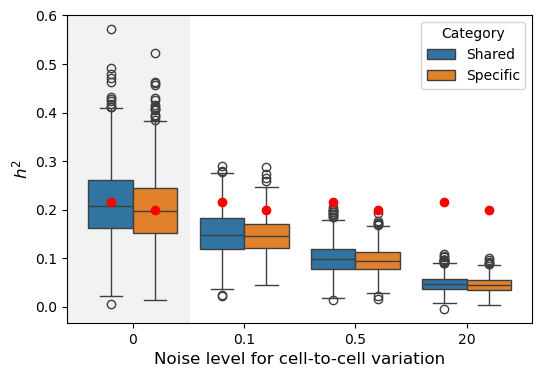

In [ ]:
nu_noises = he_nu.keys()
nu_noises = sorted(nu_noises)

# simulate expected h2 under noisy nu
ss_out = np.load('../../analysis/sim/free/L_20_nL_80/AGGss.he.npy', allow_pickle=True).item()
noisy_nu_V = np.load('../../analysis/sim/free/AGGss.true_V.npy', allow_pickle=True).item()['1000']
noisy_nu_W = np.load('../../analysis/sim/free/AGGss.true_W.npy', allow_pickle=True).item()['1000']
noisy_nu_V_bar = np.mean(np.diag(noisy_nu_V))
noisy_nu_W_bar = np.mean(np.diag(noisy_nu_W))
noisy_nu_real_shared_h2 = Hom_g2 / (Hom_g2 + noisy_nu_V_bar + Hom_e2 + noisy_nu_W_bar)
noisy_nu_real_specific_h2 = noisy_nu_V_bar / (Hom_g2 + noisy_nu_V_bar + Hom_e2 + noisy_nu_W_bar)

noisy_nu_real_h2 = np.array([[noisy_nu_real_shared_h2] * 4, [noisy_nu_real_specific_h2] * 4]).T.flatten()
print(noisy_nu_real_h2)
reml_nu = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/out.reml.noisy_nu.npy', allow_pickle=True).item()
noisy_nu_data = []

for noise, out in zip([0] + nu_noises, [ss_out['1000']] + [reml_nu[key] for key in nu_noises]):
    tmp_df = util.read_out(out, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
    shared_h2 = tmp_df['free:hom_g2'] / (tmp_df['free:hom_g2'] + tmp_df['free:v'] + tmp_df['free:hom_e2'] + tmp_df['free:w'])
    specific_h2 = tmp_df['free:v'] / (tmp_df['free:hom_g2'] + tmp_df['free:v'] + tmp_df['free:hom_e2'] + tmp_df['free:w'])
    tmp = {'Noise': str(noise), 'Shared': shared_h2, 'Specific': specific_h2}
    noisy_nu_data.append(pd.DataFrame(tmp))

noisy_nu_df = pd.concat(noisy_nu_data)
noisy_nu_df = noisy_nu_df.melt(id_vars=['Noise'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')

# plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=noisy_nu_df, x='Noise', y='h2', hue='Category', ax=ax)

ax.set_xlabel('Noise level for cell-to-cell variation', fontsize=12)
ax.set_ylabel(r'$h^2$', fontsize=12)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend().set_visible(False)
ax.tick_params(axis='both', labelsize=10)

xs = plot.snsbox_get_x(noisy_nu_df['Noise'].nunique(), 2)
ax.scatter(xs, noisy_nu_real_h2, color='r', zorder=10)

# ax.text(0.02, 0.92, "(e)", transform=ax.transAxes)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
rectangle = patches.Rectangle((xmin, ymin), (xs[2] - xs[0] + .1), ymax - ymin, edgecolor=None, facecolor='0.9', alpha=0.5, zorder=0)
ax.add_patch(rectangle)

In [11]:
for key in reml_nu.keys():
    print(key)
    df = util.read_out(reml_nu[key], ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
    df = df.rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'v', 'free:hom_e2': 'hom_e2', 'free:w': 'w'})
    df['shared_h2'] = df['hom_g2'] / (df['hom_g2'] + df['v'] + df['hom_e2'] + df['w'])
    df['specific_h2'] = df['v'] / (df['hom_g2'] + df['v'] + df['hom_e2'] + df['w'])
    df['specificity'] = df['v'] / (df['hom_g2'] + df['v'])
    display(df.describe())

    df = util.read_out(he_nu[key], ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
    df = df.rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'v', 'free:hom_e2': 'hom_e2', 'free:w': 'w'})
    df['shared_h2'] = df['hom_g2'] / (df['hom_g2'] + df['v'] + df['hom_e2'] + df['w'])
    df['specific_h2'] = df['v'] / (df['hom_g2'] + df['v'] + df['hom_e2'] + df['w'])
    df['specificity'] = df['v'] / (df['hom_g2'] + df['v'])
    display(df.describe())

0.1


,hom_g2,v,hom_e2,w,shared_h2,specific_h2,specificity
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.126110,0.121087,0.110188,0.471336,0.151571,0.146596,0.494748
std,0.039869,0.030303,0.037321,0.067228,0.044042,0.036467,0.113111
min,0.017416,0.034032,-0.026875,0.282964,0.022642,0.044705,0.171186
25%,0.098293,0.099784,0.084581,0.429102,0.120054,0.120352,0.413802
50%,0.123488,0.119829,0.110817,0.470275,0.148372,0.146168,0.490386
75%,0.152774,0.141567,0.132989,0.513644,0.182477,0.171474,0.569992
max,0.297302,0.237938,0.225441,0.753345,0.289731,0.288524,0.921210


,hom_g2,v,hom_e2,w,shared_h2,specific_h2,specificity
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.127775,0.118890,0.108045,0.254369,0.213261,0.200306,0.484395
std,0.044772,0.039413,0.053276,0.111751,0.075725,0.071859,0.136661
min,0.003496,0.009059,-0.066707,-0.091755,0.006433,0.012305,0.061365
25%,0.097235,0.092209,0.071461,0.179378,0.160136,0.149242,0.395430
50%,0.124359,0.116110,0.110782,0.251947,0.203905,0.194124,0.479707
75%,0.154883,0.142887,0.141774,0.327273,0.257623,0.243377,0.573052
max,0.322615,0.251972,0.273694,0.690496,0.535298,0.499889,0.976397


0.5


,hom_g2,v,hom_e2,w,shared_h2,specific_h2,specificity
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.126018,0.121849,0.110533,0.910193,0.099025,0.096123,0.495290
std,0.041229,0.034576,0.042211,0.079265,0.030892,0.026711,0.121420
min,0.018908,0.018801,-0.010771,0.642549,0.013207,0.015297,0.072477
25%,0.096889,0.097016,0.081312,0.856774,0.077952,0.077670,0.413485
50%,0.123247,0.120505,0.109999,0.911425,0.097593,0.094907,0.491967
75%,0.152147,0.144753,0.140151,0.959584,0.118706,0.113429,0.572786
max,0.277558,0.275735,0.256714,1.170036,0.204878,0.192605,0.935828


,hom_g2,v,hom_e2,w,shared_h2,specific_h2,specificity
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.127775,0.118894,0.108045,0.245526,0.216950,0.203869,0.484414
std,0.044772,0.039409,0.053276,0.114185,0.077765,0.074389,0.136646
min,0.003496,0.009416,-0.066707,-0.093954,0.006595,0.013467,0.056416
25%,0.097235,0.092684,0.071461,0.167343,0.163016,0.152449,0.396143
50%,0.124359,0.116307,0.110782,0.242916,0.208292,0.197901,0.480143
75%,0.154883,0.142894,0.141774,0.322647,0.262175,0.247612,0.573430
max,0.322615,0.252953,0.273694,0.697301,0.561395,0.502977,0.976407


20


,hom_g2,v,hom_e2,w,shared_h2,specific_h2,specificity
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.126281,0.120740,0.110984,2.323800,0.046987,0.045037,0.490900
std,0.045783,0.041671,0.055750,0.114305,0.016640,0.015455,0.145913
min,-0.010305,0.009393,-0.083095,1.960656,-0.003897,0.003371,0.041387
25%,0.095619,0.089955,0.072687,2.247228,0.035811,0.033781,0.390427
50%,0.123231,0.119917,0.113082,2.321554,0.046225,0.044757,0.492271
75%,0.154905,0.148209,0.149341,2.398685,0.057248,0.055330,0.590672
max,0.309011,0.263581,0.325335,2.693703,0.109611,0.100277,1.073525


,hom_g2,v,hom_e2,w,shared_h2,specific_h2,specificity
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.127775,0.118908,0.108045,0.253279,0.215120,0.202124,0.484454
std,0.044772,0.039388,0.053276,0.120436,0.078541,0.074792,0.136570
min,0.003496,0.007847,-0.066707,-0.060019,0.006734,0.011033,0.056356
25%,0.097235,0.092516,0.071461,0.170190,0.162497,0.149416,0.396767
50%,0.124359,0.116234,0.110782,0.253280,0.206858,0.195988,0.480046
75%,0.154883,0.142963,0.141774,0.332031,0.262171,0.246918,0.572772
max,0.322615,0.252435,0.273694,0.734257,0.625899,0.518361,0.976427


## Non-Gaussian

In [24]:
reml_nongauss = np.load('../../staging/sim/free/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/spikeslab_g.spikeslab_e.out.reml.npy', allow_pickle=True).item()

In [25]:
print(reml_nongauss.keys())

dict_keys(['gene', 'free', 'wald'])


In [27]:
df = util.read_out(reml_nongauss, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
df = df.rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'v', 'free:hom_e2': 'hom_e2', 'free:w': 'w'})
df['shared_h2'] = df['hom_g2'] / (df['hom_g2'] + df['v'] + df['hom_e2'] + df['w'])
df['specific_h2'] = df['v'] / (df['hom_g2'] + df['v'] + df['hom_e2'] + df['w'])
df['specificity'] = df['v'] / (df['hom_g2'] + df['v'])
display(df.describe())

# df = util.read_out(he_nu[key], ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
# df = df.rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'v', 'free:hom_e2': 'hom_e2', 'free:w': 'w'})
# df['shared_h2'] = df['hom_g2'] / (df['hom_g2'] + df['v'] + df['hom_e2'] + df['w'])
# df['specific_h2'] = df['v'] / (df['hom_g2'] + df['v'] + df['hom_e2'] + df['w'])
# df['specificity'] = df['v'] / (df['hom_g2'] + df['v'])
# display(df.describe())

,hom_g2,v,hom_e2,w,shared_h2,specific_h2,specificity
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.128348,0.123510,0.108668,0.241626,0.210284,0.206778,0.502781
std,0.051332,0.032003,0.034569,0.052276,0.073997,0.056132,0.139968
min,0.002551,0.013453,-0.003388,0.085145,0.005366,0.025948,0.092307
25%,0.090757,0.102245,0.084665,0.205110,0.156903,0.168880,0.408659
50%,0.125127,0.122454,0.108803,0.241045,0.210377,0.205784,0.496028
75%,0.162201,0.144683,0.132673,0.274992,0.257803,0.239947,0.600267
max,0.326468,0.225653,0.224111,0.407895,0.438683,0.391674,0.982135


# GCTA alg

In [38]:
gcta_out = np.load('../../analysis/sim/free3/L_20_nL_80/AGGvc.greml.npy', allow_pickle=True).item()
gcta_aireml_out = np.load('../../analysis/sim/free3/L_20_nL_80/AGGvc.greml.aireml.npy', allow_pickle=True).item()

In [32]:
print(gcta_aireml_out.keys())
print(gcta_aireml_out['0.13_0.13_0.11_0.04_0.08_0.51'].keys())
print(gcta_aireml_out['0.13_0.13_0.11_0.04_0.08_0.51']['greml_ctp']['V(G)/Vp']['variance'].shape)

dict_keys(['0.13_0.13_0.11_0.04_0.08_0.51', '0.086_0.086_0.073_0.026_0.053_0.676', '0.174_0.174_0.148_0.054_0.107_0.343', '0.211_0.211_0.178_0.065_0.13_0.205', '0.266_0.265_0.224_0.082_0.163_0'])
dict_keys(['gene', 'greml_ctp', 'greml_op', 'alg', 'log', 'alg2', 'log2'])
(1000, 4)


In [39]:
for key in gcta_aireml_out.keys():
    print(key)
    print(np.unique(gcta_aireml_out[key]['alg'], return_counts=True))
    i, j, k = 0, 0, 0
    for log in gcta_aireml_out[key]['log']:
        if 'stop after 10000 iteractions' in log:
            i += 1
        if 'the information matrix is not invertible' in log:
            j += 1
        if 'error' in log:
            k += 1
    print(f"Stopped after 10000 iterations: {i} times")
    print(f"Information matrix not invertible: {j} times")
    print(f"Errors: {k} times")

0.13_0.13_0.11_0.04_0.08_0.51
(array(['AI', 'EM'], dtype='<U2'), array([830, 170]))
Stopped after 10000 iterations: 1 times
Information matrix not invertible: 169 times
Errors: 170 times
0.086_0.086_0.073_0.026_0.053_0.676
(array(['AI', 'EM'], dtype='<U2'), array([400, 600]))
Stopped after 10000 iterations: 0 times
Information matrix not invertible: 599 times
Errors: 599 times
0.174_0.174_0.148_0.054_0.107_0.343
(array(['AI', 'EM'], dtype='<U2'), array([992,   8]))
Stopped after 10000 iterations: 0 times
Information matrix not invertible: 8 times
Errors: 8 times
0.211_0.211_0.178_0.065_0.13_0.205
(array(['AI'], dtype='<U2'), array([1000]))
Stopped after 10000 iterations: 0 times
Information matrix not invertible: 0 times
Errors: 0 times
0.266_0.265_0.224_0.082_0.163_0
(array(['AI'], dtype='<U2'), array([1000]))
Stopped after 10000 iterations: 0 times
Information matrix not invertible: 0 times
Errors: 0 times


0.086_0.086_0.073_0.026_0.053_0.676
(1000,) (1000,)
0.13_0.13_0.11_0.04_0.08_0.51
(1000,) (1000,)
0.174_0.174_0.148_0.054_0.107_0.343
(1000,) (1000,)
0.211_0.211_0.178_0.065_0.13_0.205
(1000,) (1000,)
0.266_0.265_0.224_0.082_0.163_0
(1000,) (1000,)


0.086_0.086_0.073_0.026_0.053_0.676
(1000,) (1000,)
0.13_0.13_0.11_0.04_0.08_0.51
(1000,) (1000,)
0.174_0.174_0.148_0.054_0.107_0.343
(1000,) (1000,)
0.211_0.211_0.178_0.065_0.13_0.205
(1000,) (1000,)
0.266_0.265_0.224_0.082_0.163_0
(1000,) (1000,)


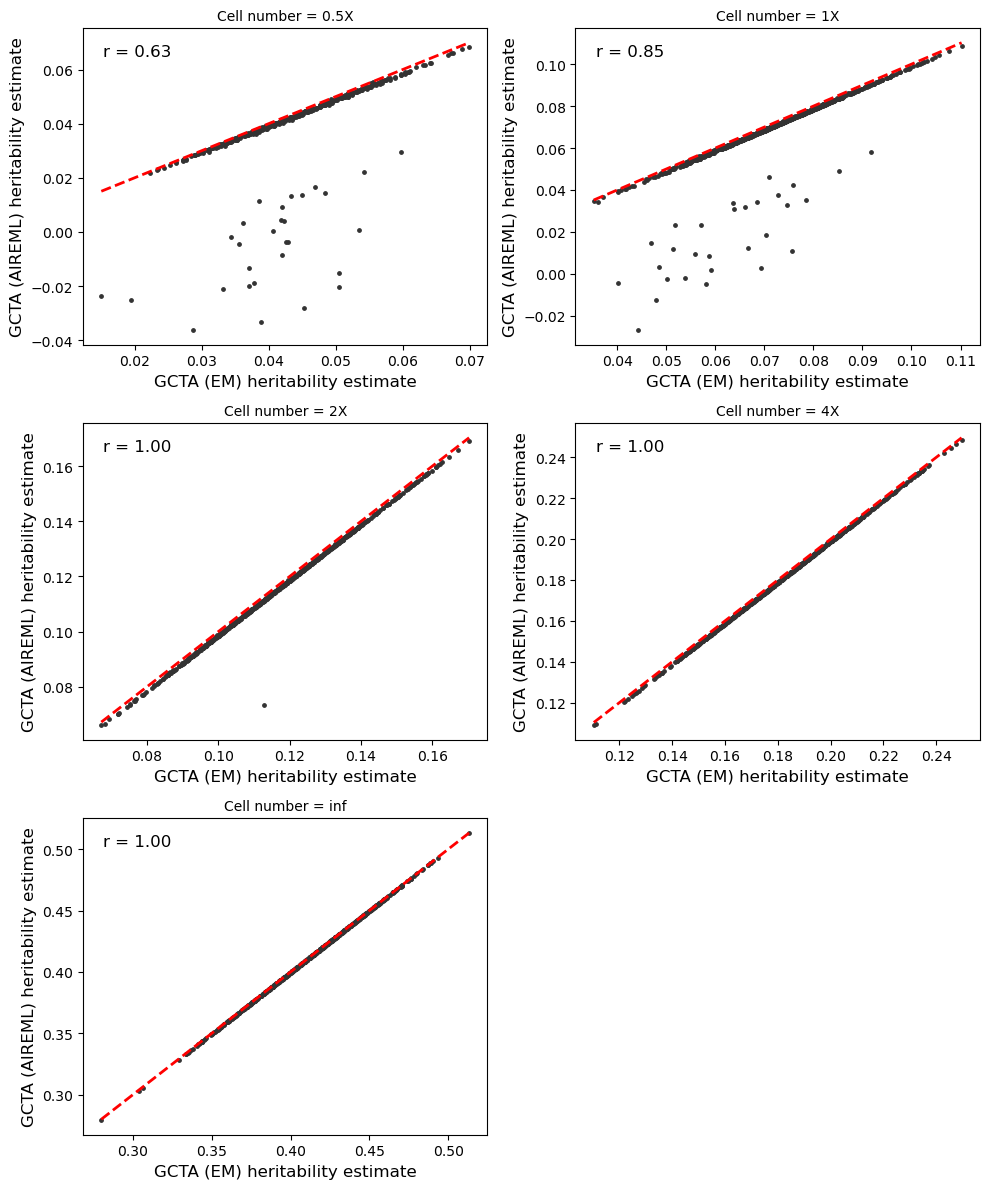

In [69]:
# plot 
# NS = [0.5, 1, 2, 4, 10000]

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for key, cell_no, ax in zip(Nu_vcs, Cell_no, axes.flatten()):
    print(key)
    em_var = gcta_out[key]['greml_ctp']['V(G)/Vp']['variance'].mean(axis=1)
    aireml_var = gcta_aireml_out[key]['greml_ctp']['V(G)/Vp']['variance'].mean(axis=1)
    print(em_var.shape, aireml_var.shape)
    # filter AI
    idx = gcta_aireml_out[key]['alg'] == 'AI'
    em_var = em_var[idx]
    aireml_var = aireml_var[idx]
    # scatter plot
    ax.scatter(em_var, aireml_var, color='.2', marker='o', s=6)
    ax.set_title(f'Cell number = {cell_no}', fontsize=10)
    ax.set_xlabel('GCTA (EM) heritability estimate', fontsize=12)
    ax.set_ylabel('GCTA (AIREML) heritability estimate', fontsize=12)

    # add y=x line
    min_var = np.nanmin(em_var)
    max_var = np.nanmax(em_var)
    ax.plot([min_var, max_var], [min_var, max_var], color='r', linestyle='--', linewidth=2)

    # calculate correlation and add to the plot
    r, p = stats.pearsonr(em_var, aireml_var)
    ax.text(0.05, 0.95, f'r = {r:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

axes[2, 1].axis('off')  # hide the last subplot

fig.tight_layout()

# Real genotype

In [10]:
realgeno_1000 = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_200_nL_80/out.realgeno.he.npy', allow_pickle=True).item()
realgeno_500 = np.load('../../analysis/sim/free/ss~500_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_200_nL_80/out.realgeno.he.npy', allow_pickle=True).item()
realgeno_data = []

tmp = {'Sample size': 500, 'Shared': realgeno_500['free']['shared_h2'], 'Specific': realgeno_500['free']['specific_h2']}
realgeno_data.append(pd.DataFrame(tmp))

tmp = {'Sample size': 1000, 'Shared': realgeno_1000['free']['shared_h2'], 'Specific': realgeno_1000['free']['specific_h2']}
realgeno_data.append(pd.DataFrame(tmp))

realgeno_data = pd.concat(realgeno_data)
realgeno_data = realgeno_data.melt(id_vars=['Sample size'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')

In [6]:
print(realgeno_500.keys())
print(realgeno_500['free'].keys())
print(realgeno_500['gene'])

dict_keys(['gene', 'iid', 'free', 's', 'pi', 'nu', 'var_y', 'wald'])
dict_keys(['hom_g2', 'hom_e2', 'V', 'W', 'shared_h2', 'specific_h2', 'r2', 'ctnu', 'nu', 'beta', 'ct_beta', 'op_fixed_vars', 'op_random_vars'])
['ENSG00000235249' 'ENSG00000185097' 'ENSG00000177757' ...
 'ENSG00000251322' 'ENSG00000100312' 'ENSG00000079974']


In [11]:
# SNPs
gene_snps = {}
for i in range(500):
    tmp_data = np.load(f'../../staging/sim/free/ss~500_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_200_nL_80/realgeno/sim.batch{i}.npy', allow_pickle=True).item()
    for gene, value in tmp_data.items():
        gene_snps[str(gene)] = value['G'].shape[1]
# print(gene_snps)
gene_snps_df = pd.DataFrame(list(gene_snps.items()), columns=['gene', 'n_snps'])

shared_h2                                                              \
          count      mean       std       min       25%       50%       75%   
group                                                                         
0        3963.0  0.192018  0.181863 -0.331945  0.065792  0.151611  0.272317   
1        3963.0  0.201293  0.167966 -0.168669  0.083065  0.168733  0.281646   
2        3960.0  0.211035  0.163631 -0.232898  0.098652  0.176728  0.287268   
3        3958.0  0.206977  0.160206 -0.207099  0.092458  0.179931  0.285695   
4        3958.0  0.215581  0.157307 -0.119614  0.105317  0.190458  0.296553   

                specific_h2            ...                      n_snps  \
            max       count      mean  ...       75%       max   count   
group                                  ...                               
0      1.220608      3963.0  0.186648  ...  0.240966  2.309632  3963.0   
1      1.926131      3963.0  0.200546  ...  0.259340  1.186798  3963.0   
2      1.402245      3960.0  0.206002  ...  0.267350  1.635728  3960.0   
3      1.328610      3958.0  0.203666  ...  0.267735  1.499385  3958.0   
4      1.131749      3958.0  0.204375  ...  0.269921  1.427419  3958.0   

                                                                          
              mean         std     min     25%     50%      75%      max  
group                                                                     
0      1100.085289  273.970833   206.0   943.0  1163.0  1316.00   1458.0  
1      1652.485743  102.494621  1459.0  1568.0  1660.0  1740.00   1821.0  
2      1971.749242   86.922989  1822.0  1897.0  1970.0  2044.00   2128.0  
3      2298.909550  101.500384  2129.0  2212.0  2296.0  2385.00   2483.0  
4      3040.745326  794.397381  2484.0  2608.0  2785.0  3117.75  15926.0  

[5 rows x 24 columns]

shared_h2                                                              \
          count      mean       std       min       25%       50%       75%   
group                                                                         
0        3963.0  0.192018  0.181863 -0.331945  0.065792  0.151611  0.272317   
1        3963.0  0.201293  0.167966 -0.168669  0.083065  0.168733  0.281646   
2        3960.0  0.211035  0.163631 -0.232898  0.098652  0.176728  0.287268   
3        3958.0  0.206977  0.160206 -0.207099  0.092458  0.179931  0.285695   
4        3958.0  0.215581  0.157307 -0.119614  0.105317  0.190458  0.296553   

                specific_h2            ...                      n_snps  \
            max       count      mean  ...       75%       max   count   
group                                  ...                               
0      1.220608      3963.0  0.186648  ...  0.240966  2.309632  3963.0   
1      1.926131      3963.0  0.200546  ...  0.259340  1.186798  3963.0   
2      1.402245      3960.0  0.206002  ...  0.267350  1.635728  3960.0   
3      1.328610      3958.0  0.203666  ...  0.267735  1.499385  3958.0   
4      1.131749      3958.0  0.204375  ...  0.269921  1.427419  3958.0   

                                                                          
              mean         std     min     25%     50%      75%      max  
group                                                                     
0      1100.085289  273.970833   206.0   943.0  1163.0  1316.00   1458.0  
1      1652.485743  102.494621  1459.0  1568.0  1660.0  1740.00   1821.0  
2      1971.749242   86.922989  1822.0  1897.0  1970.0  2044.00   2128.0  
3      2298.909550  101.500384  2129.0  2212.0  2296.0  2385.00   2483.0  
4      3040.745326  794.397381  2484.0  2608.0  2785.0  3117.75  15926.0  

[5 rows x 24 columns]

[2026-02-09 09:13:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-09 09:13:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


shared_h2                                                              \
          count      mean       std       min       25%       50%       75%   
group                                                                         
0        3963.0  0.192018  0.181863 -0.331945  0.065792  0.151611  0.272317   
1        3963.0  0.201293  0.167966 -0.168669  0.083065  0.168733  0.281646   
2        3960.0  0.211035  0.163631 -0.232898  0.098652  0.176728  0.287268   
3        3958.0  0.206977  0.160206 -0.207099  0.092458  0.179931  0.285695   
4        3958.0  0.215581  0.157307 -0.119614  0.105317  0.190458  0.296553   

                specific_h2            ...                      n_snps  \
            max       count      mean  ...       75%       max   count   
group                                  ...                               
0      1.220608      3963.0  0.186648  ...  0.240966  2.309632  3963.0   
1      1.926131      3963.0  0.200546  ...  0.259340  1.186798  3963.0   
2      1.402245      3960.0  0.206002  ...  0.267350  1.635728  3960.0   
3      1.328610      3958.0  0.203666  ...  0.267735  1.499385  3958.0   
4      1.131749      3958.0  0.204375  ...  0.269921  1.427419  3958.0   

                                                                          
              mean         std     min     25%     50%      75%      max  
group                                                                     
0      1100.085289  273.970833   206.0   943.0  1163.0  1316.00   1458.0  
1      1652.485743  102.494621  1459.0  1568.0  1660.0  1740.00   1821.0  
2      1971.749242   86.922989  1822.0  1897.0  1970.0  2044.00   2128.0  
3      2298.909550  101.500384  2129.0  2212.0  2296.0  2385.00   2483.0  
4      3040.745326  794.397381  2484.0  2608.0  2785.0  3117.75  15926.0  

[5 rows x 24 columns]

[2026-02-09 09:13:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-09 09:13:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


shared_h2                                                              \
          count      mean       std       min       25%       50%       75%   
group                                                                         
0        3963.0  0.192018  0.181863 -0.331945  0.065792  0.151611  0.272317   
1        3963.0  0.201293  0.167966 -0.168669  0.083065  0.168733  0.281646   
2        3960.0  0.211035  0.163631 -0.232898  0.098652  0.176728  0.287268   
3        3958.0  0.206977  0.160206 -0.207099  0.092458  0.179931  0.285695   
4        3958.0  0.215581  0.157307 -0.119614  0.105317  0.190458  0.296553   

                specific_h2            ...                      n_snps  \
            max       count      mean  ...       75%       max   count   
group                                  ...                               
0      1.220608      3963.0  0.186648  ...  0.240966  2.309632  3963.0   
1      1.926131      3963.0  0.200546  ...  0.259340  1.186798  3963.0   
2      1.402245      3960.0  0.206002  ...  0.267350  1.635728  3960.0   
3      1.328610      3958.0  0.203666  ...  0.267735  1.499385  3958.0   
4      1.131749      3958.0  0.204375  ...  0.269921  1.427419  3958.0   

                                                                          
              mean         std     min     25%     50%      75%      max  
group                                                                     
0      1100.085289  273.970833   206.0   943.0  1163.0  1316.00   1458.0  
1      1652.485743  102.494621  1459.0  1568.0  1660.0  1740.00   1821.0  
2      1971.749242   86.922989  1822.0  1897.0  1970.0  2044.00   2128.0  
3      2298.909550  101.500384  2129.0  2212.0  2296.0  2385.00   2483.0  
4      3040.745326  794.397381  2484.0  2608.0  2785.0  3117.75  15926.0  

[5 rows x 24 columns]

[2026-02-09 09:13:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-09 09:13:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


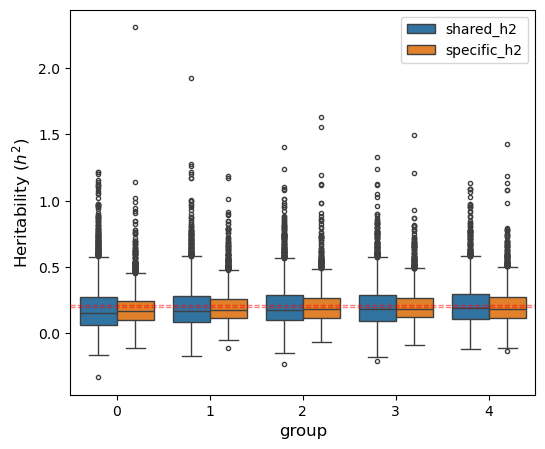

In [12]:
# 
data = pd.DataFrame({'gene': realgeno_500['gene'], 'shared_h2': realgeno_500['free']['shared_h2'], 'specific_h2': realgeno_500['free']['specific_h2']})
data = data.merge(gene_snps_df, on='gene')
data = data.sort_values('n_snps')
# split data into bins based on n_snps
data['group'] = pd.qcut(data['n_snps'], q=5, labels=False)
display(data.groupby('group').describe())
data = data.melt(id_vars=['gene', 'n_snps', 'group'], value_vars=['shared_h2', 'specific_h2'], var_name='Category', value_name='h2')

fig, ax = plt.subplots(figsize=(6, 5),)
sns.boxplot(data=data, x='group', y='h2', hue='Category', ax=ax, flierprops=dict(marker='.'))

ax.set_xlabel('group', fontsize=12)
ax.set_ylabel(r'Heritability ($h^2$)', fontsize=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, fontsize=10)
plt.tick_params(axis='x', labelsize=10)

ax.axhline(ss_h2[0], color='r', linestyle='--', linewidth=1, alpha=0.5, zorder=10)
ax.axhline(ss_h2[1], color='r', linestyle='--', linewidth=1, alpha=0.5, zorder=10)


,shared_h2,specific_h2,n_snps
group,,,
0,0.151544,0.165332,1163.0
1,0.172588,0.176489,1660.0
2,0.177957,0.181829,1970.0
3,0.181747,0.184232,2296.0
4,0.190824,0.187599,2785.0


,shared_h2,specific_h2,n_snps
group,,,
0,0.151544,0.165332,1163.0
1,0.172588,0.176489,1660.0
2,0.177957,0.181829,1970.0
3,0.181747,0.184232,2296.0
4,0.190824,0.187599,2785.0


[2026-02-09 09:19:10 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-09 09:19:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


,shared_h2,specific_h2,n_snps
group,,,
0,0.151544,0.165332,1163.0
1,0.172588,0.176489,1660.0
2,0.177957,0.181829,1970.0
3,0.181747,0.184232,2296.0
4,0.190824,0.187599,2785.0


[2026-02-09 09:19:10 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-09 09:19:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


,shared_h2,specific_h2,n_snps
group,,,
0,0.151544,0.165332,1163.0
1,0.172588,0.176489,1660.0
2,0.177957,0.181829,1970.0
3,0.181747,0.184232,2296.0
4,0.190824,0.187599,2785.0


[2026-02-09 09:19:10 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-09 09:19:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


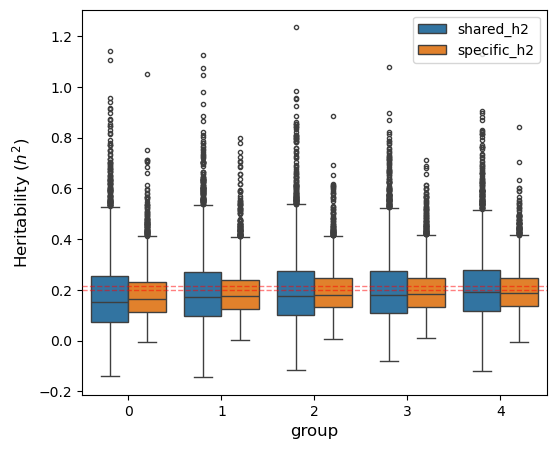

In [17]:
# 
data = pd.DataFrame({'gene': realgeno_1000['gene'], 'shared_h2': realgeno_1000['free']['shared_h2'], 'specific_h2': realgeno_1000['free']['specific_h2']})
data = data.merge(gene_snps_df, on='gene')
data = data.sort_values('n_snps')
# split data into bins based on n_snps
data['group'] = pd.qcut(data['n_snps'], q=5, labels=False)
display(data.groupby('group')[['shared_h2', 'specific_h2', 'n_snps']].median())
data = data.melt(id_vars=['gene', 'n_snps', 'group'], value_vars=['shared_h2', 'specific_h2'], var_name='Category', value_name='h2')

fig, ax = plt.subplots(figsize=(6, 5),)
sns.boxplot(data=data, x='group', y='h2', hue='Category', ax=ax, flierprops=dict(marker='.'))

ax.set_xlabel('group', fontsize=12)
ax.set_ylabel(r'Heritability ($h^2$)', fontsize=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, fontsize=10)
plt.tick_params(axis='x', labelsize=10)

ax.axhline(ss_h2[0], color='r', linestyle='--', linewidth=1, alpha=0.5, zorder=10)
ax.axhline(ss_h2[1], color='r', linestyle='--', linewidth=1, alpha=0.5, zorder=10)


In [4]:
ss = [500, 1000]
ss_Vs = np.load('../../analysis/sim/free/AGGss.true_V.npy', allow_pickle=True).item()
ss_Ws = np.load('../../analysis/sim/free/AGGss.true_W.npy', allow_pickle=True).item()

## calculate simulated h2
ss_shared_h2 = []
ss_specific_h2 = []

for key in ss:
    key = str(key)
    V, W = ss_Vs[key], ss_Ws[key]
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    ss_shared_h2.append(Hom_g2 / (Hom_g2 + V_bar + Hom_e2 + W_bar))
    ss_specific_h2.append(V_bar / (Hom_g2 + V_bar + Hom_e2 + W_bar))

ss_h2 = np.array([ss_shared_h2, ss_specific_h2]).T.flatten()
print(ss_h2)

[0.21666667 0.2        0.21666667 0.2       ]


[2026-02-08 20:50:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-08 20:50:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[2026-02-08 20:50:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-08 20:50:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[2026-02-08 20:50:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2026-02-08 20:50:09 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


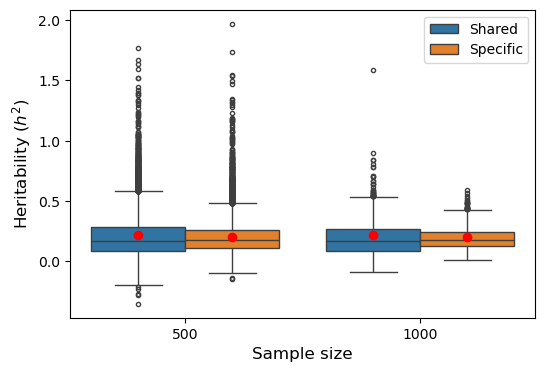

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(data=realgeno_data, x='Sample size', y='h2', hue='Category', ax=ax, flierprops=dict(marker='.'))

ax.set_xlabel('Sample size', fontsize=12)
ax.set_ylabel(r'Heritability ($h^2$)', fontsize=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, fontsize=10)
plt.tick_params(axis='x', labelsize=10)

xs = plot.snsbox_get_x(len(ss), 2)
ax.scatter(xs, ss_h2, color='r', zorder=10)
# ax.set_ylim(-.1, .9)


[0.12 0.12 0.12 0.12]
[0.24 0.24 0.24 0.24]
0.12000000000000001
0.24000000000000002
0.13 0.11


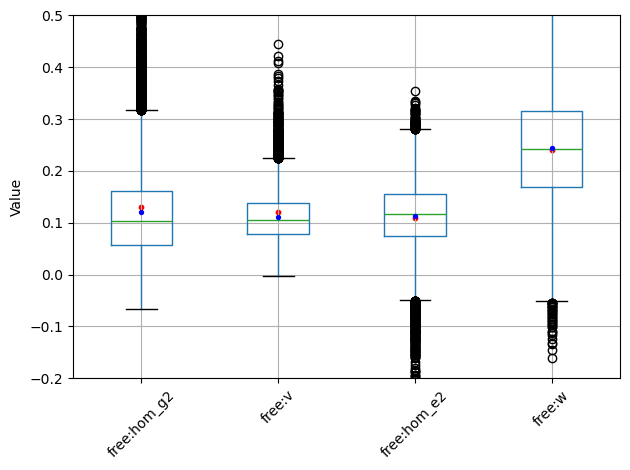

In [51]:
ss_Vs = np.load('../../analysis/sim/free/AGGss.true_V.npy', allow_pickle=True).item()
ss_Ws = np.load('../../analysis/sim/free/AGGss.true_W.npy', allow_pickle=True).item()

key = str(1000)
V, W = ss_Vs[key], ss_Ws[key]
V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
print(np.diag(V))
print(np.diag(W))
print(V_bar)
print(W_bar)
print(Hom_g2, Hom_e2)

# boxplot for hom_g2, v, hom_e2, w
tmp_realgeno_1000 = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.13_0.13_0.11_0.04_0.08_0.51_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/out.realgeno.he.npy', allow_pickle=True).item()
tmp_data = util.read_out(tmp_realgeno_1000, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])

fig, ax = plt.subplots()
tmp_data[['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w']].boxplot(ax=ax)
# add mean values
ax.scatter(np.arange(1,5), tmp_data.mean(), color='b', s=8, zorder=10)
# add expected value
ax.scatter(np.arange(1, 5), [Hom_g2, V_bar, Hom_e2, W_bar], color='r', s=10)
ax.set_ylim((-.2, .5))
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.tight_layout()
plt.show()

dict_keys(['gene', 'iid', 'free', 's', 'pi', 'nu', 'var_y', 'wald'])


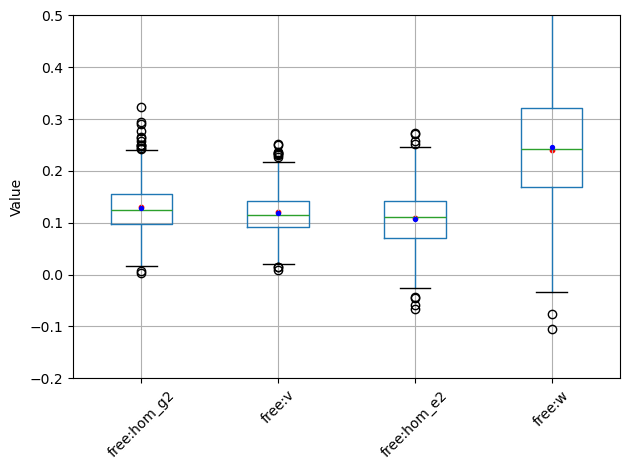

In [42]:
print(ss_out['1000'].keys())
tmp_ss_data = util.read_out(ss_out['1000'], ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
tmp_ss_data.describe()

# boxplot for hom_g2, v, hom_e2, w
fig, ax = plt.subplots()
tmp_ss_data[['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w']].boxplot(ax=ax)
# add mean values
ax.scatter(np.arange(1,5), tmp_ss_data.mean(), color='b', s=8, zorder=10)
# add expected value
ax.scatter(np.arange(1, 5), [Hom_g2, V_bar, Hom_e2, W_bar], color='r', s=10)
ax.set_ylim((-.2, .5))
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.tight_layout()
plt.show()

dict_keys(['gene', 'free', 's', 'pi', 'nu', 'var_y', 'wald'])
       free:hom_g2       free:v  free:hom_e2       free:w
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      0.053902     0.050434     0.357134     0.613858
std       0.020683     0.010470     0.039316     0.019450
min       0.011218     0.023169     0.258743     0.554688
25%       0.038875     0.043165     0.330398     0.601263
50%       0.050341     0.049434     0.355060     0.614282
75%       0.064634     0.057063     0.382232     0.626831
max       0.147213     0.095582     0.494336     0.681420


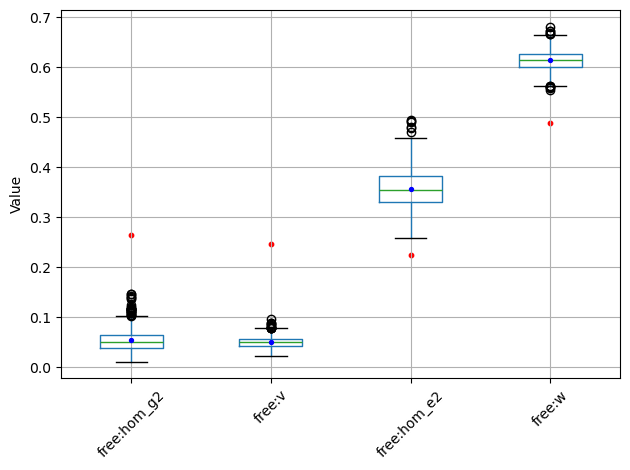

In [18]:
# simulate LD
tmp_out = np.load('../../analysis/sim/free3/ss~1000_a~2_2_2_2_vc~0.266_0.265_0.224_0.082_0.163_0_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/ld0.2/out.he.npy', allow_pickle=True).item()
print(tmp_out.keys())
tmp_ss_data = util.read_out(tmp_out, ['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w'])
print(tmp_ss_data.describe())
nu_Vs = np.load('../../analysis/sim/free3/AGGvc.true_V.npy', allow_pickle=True).item()
nu_Ws = np.load('../../analysis/sim/free3/AGGvc.true_W.npy', allow_pickle=True).item()
V_bar = np.diag(nu_Vs['0.266_0.265_0.224_0.082_0.163_0']).mean()
W_bar = np.diag(nu_Ws['0.266_0.265_0.224_0.082_0.163_0']).mean()

# boxplot for hom_g2, v, hom_e2, w
fig, ax = plt.subplots()
tmp_ss_data[['free:hom_g2', 'free:v', 'free:hom_e2', 'free:w']].boxplot(ax=ax)
# add mean values
ax.scatter(np.arange(1,5), tmp_ss_data.mean(), color='b', s=8, zorder=10)
# add expected value
ax.scatter(np.arange(1, 5), [0.265, V_bar, 0.224, W_bar], color='r', s=10)
# ax.set_ylim((-.2, .5))
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [10]:
# greml
greml = np.load('../../analysis/sim/free3/ss~1000_a~2_2_2_2_vc~0.266_0.265_0.224_0.082_0.163_0_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/ld0.2/greml.npy', allow_pickle=True).item()
nu_Vs = np.load('../../analysis/sim/free3/AGGvc.true_V.npy', allow_pickle=True).item()
nu_Ws = np.load('../../analysis/sim/free3/AGGvc.true_W.npy', allow_pickle=True).item()

print(greml['greml_ctp']['V(G)'].keys())
print(greml['greml_ctp']['V(G)']['variance'][0])
print(greml['greml_ctp']['V(e)']['variance'][0])
print(greml['greml_ctp']['V(G)']['variance'].mean(axis=0))
print(greml['greml_ctp']['V(e)']['variance'].mean(axis=0))
print(np.diag(nu_Vs['0.266_0.265_0.224_0.082_0.163_0']).mean() + 0.265)
print(np.diag(nu_Ws['0.266_0.265_0.224_0.082_0.163_0']).mean() + 0.224)

dict_keys(['variance', 'se'])
[0.639155 0.47741  0.582814 0.646873]
[0.672759 0.693129 0.664025 0.666303]
[0.50937251 0.51274486 0.50852181 0.51094534]
[0.71140787 0.71318958 0.71358391 0.71234307]
0.511
0.7130000000000001


In [15]:
# bolt
bolt = np.load('../../analysis/sim/free3/ss~1000_a~2_2_2_2_vc~0.266_0.265_0.224_0.082_0.163_0_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/ld0.2/bolt.npy', allow_pickle=True).item()
nu_Vs = np.load('../../analysis/sim/free3/AGGvc.true_V.npy', allow_pickle=True).item()
nu_Ws = np.load('../../analysis/sim/free3/AGGvc.true_W.npy', allow_pickle=True).item()
print(bolt.keys())
print(bolt['hom_g2'].mean())
print(bolt['vbar'].mean())
print(np.diag(nu_Vs['0.266_0.265_0.224_0.082_0.163_0']).mean())
print(bolt['hom_e2'].mean())
print(bolt['wbar'].mean())
print(np.diag(nu_Ws['0.266_0.265_0.224_0.082_0.163_0']).mean())
print(np.median(bolt['shared_h2']))
print(np.median(bolt['specific_h2']))
print(0.265 / (0.265 + np.diag(nu_Vs['0.266_0.265_0.224_0.082_0.163_0']).mean() + 0.224 + np.diag(nu_Ws['0.266_0.265_0.224_0.082_0.163_0']).mean()))
print(np.diag(nu_Vs['0.266_0.265_0.224_0.082_0.163_0']).mean() / (0.265 + np.diag(nu_Vs['0.266_0.265_0.224_0.082_0.163_0']).mean() + 0.224 + np.diag(nu_Ws['0.266_0.265_0.224_0.082_0.163_0']).mean()))

dict_keys(['gene', 'shared_h2', 'specific_h2', 'sigma_g2', 'sigma_e2', 'hom_g2', 'vbar', 'hom_e2', 'wbar'])
0.3002764412720488
0.28193899267858397
0.24600000000000002
0.24997246028690698
0.5527194112218325
0.48900000000000005
0.21392492221300222
0.20554727452517224
0.21650326797385622
0.20098039215686278


In [37]:
tmp_out = np.load('../../analysis/sim/free3/ss~1000_a~2_2_2_2_vc~0.266_0.265_0.224_0.082_0.163_0_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/ld0.2/out.he.npy', allow_pickle=True).item()
g1 = np.load('../../staging/sim/free3/ss~1000_a~2_2_2_2_vc~0.266_0.265_0.224_0.082_0.163_0_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/ld0.2/he.batch0.npy', allow_pickle=True)

print(g1[0]['free']['hom_g2'])
print(tmp_out['free']['hom_g2'].mean())

0.05687550621352708
0.05390230789437568


In [12]:
data_g1 = np.load('../../staging/sim/free3/ss~1000_a~2_2_2_2_vc~0.266_0.265_0.224_0.082_0.163_0_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/ld0.2/sim.batch0.npy', allow_pickle=True).item()

K = data_g1[0]['K']
Y = data_g1[0]['Y']
C = Y.shape[1]
N = Y.shape[0]
X = np.kron(np.ones((N, 1)), np.eye(C))
M = np.eye(N * C) - X @ np.linalg.inv(X.T @ X) @ X.T
y = Y.flatten()
y_p = M @ y
t = np.outer(y_p, y_p)
Q = []
Q.append((M @ np.kron(K, np.ones((C, C))) @ M).flatten())
Q.append((M @ np.kron(np.eye(N), np.ones((C, C))) @ M).flatten())
for i in range(C):
    Q.append((M @ np.kron(K, np.eye(C)[:, i:i+1] @ np.eye(C)[:, i:i+1].T) @ M).flatten())

for i in range(C):
    Q.append((M @ np.kron(np.eye(N), np.eye(C)[:, i:i+1] @ np.eye(C)[:, i:i+1].T) @ M).flatten())

Q = np.array(Q)
QTQ = Q @ Q.T
QTy = Q @ t.flatten()
theta = sla.solve(QTQ, QTy)
print(theta)


[0.05687551 0.34417304 0.03451557 0.02774311 0.03298551 0.10817963
 0.64302504 0.58496546 0.6057463  0.68229934]


In [20]:
sigma_g2s = []
for i in range(500):
    data_gene = np.load(f'../../staging/sim/free3/ss~1000_a~2_2_2_2_vc~0.266_0.265_0.224_0.082_0.163_0_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/ld0.2/sim.batch{i}.npy', allow_pickle=True).item()
    for gene, value in data_gene.items():
        # print(gene)
        K = value['K']
        Y = value['Y']
        N = Y.shape[0]

        y1 = Y[:, 0]
        y1 = y1 - y1.mean()
        sigma_g2 = y1 @ (K - np.eye(N)) @ y1 / (np.trace(K @ K) - N)
        sigma_g2s.append(sigma_g2)
print(sigma_g2s)

[np.float64(0.09137090174420669), np.float64(0.17710766987337587), np.float64(0.10986286495458338), np.float64(0.07905987418759126), np.float64(0.09629768357947477), np.float64(0.08598930797697688), np.float64(0.15084098647035113), np.float64(0.13325414348034445), np.float64(0.08030395297192552), np.float64(0.11223743182646466), np.float64(0.09752748719899973), np.float64(0.13543438101897293), np.float64(0.08519022771310879), np.float64(0.05598727998373401), np.float64(0.05914000829194608), np.float64(0.06748951947612153), np.float64(0.11906122900859162), np.float64(0.10325824409597555), np.float64(0.08649174264956914), np.float64(0.13173584907151864), np.float64(0.09613364401829855), np.float64(0.16438552106219162), np.float64(0.0751637241093986), np.float64(0.1082546577067381), np.float64(0.06492476224037214), np.float64(0.12689265742370753), np.float64(0.10936678177581233), np.float64(0.10297266392743107), np.float64(0.06969603298426984), np.float64(0.10811907210006937), np.float64(

dict_keys(['hom_g2', 'hom_e2', 'V', 'W', 'shared_h2', 'specific_h2', 'r2', 'ctnu', 'nu', 'beta', 'ct_beta', 'op_fixed_vars', 'op_random_vars'])


<Axes: >

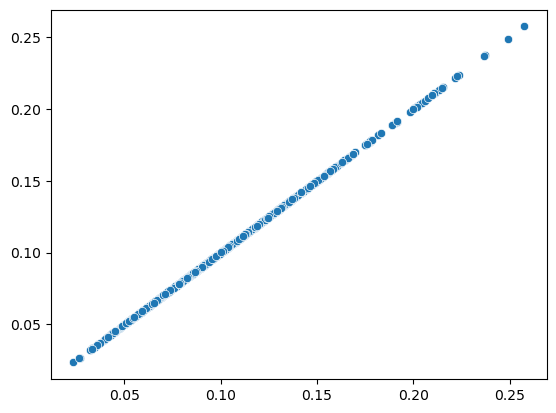

In [26]:
tmp_out = np.load('../../analysis/sim/free3/ss~1000_a~2_2_2_2_vc~0.266_0.265_0.224_0.082_0.163_0_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/L_20_nL_80/ld0.2/out.he.npy', allow_pickle=True).item()
print(tmp_out['free'].keys())
tmp_g = tmp_out['free']['hom_g2'] + tmp_out['free']['V'][:,0,0]

# plot
fig, ax = plt.subplots()
sns.scatterplot(x=tmp_g, y=sigma_g2s, ax=ax)